In [183]:
import torch
import torch.nn as nn
# from generate_data import *
import matplotlib.pyplot as plt
import numpy as np
import math
from load_matlab_timedata import get_data_from
import sklearn.preprocessing 

In [231]:
! ls DC_motor_simulation

dc_engine_random_sig_const_periods.slx	diff_eq_system.slx.original  slprj
DC_motor_simulation.prj			res.mat
diff_eq_system.slx			resources


In [232]:
plt.rcParams['figure.figsize'] = 20, 7.

In [233]:
data = get_data_from('DC_motor_simulation/res.mat')

<KeysViewHDF5 ['ans']>


## KD: choosing simple value to avoid systematic error, as we have peacewise equal periods in data

In [234]:
leave_nth = 13

In [235]:
time, x, y = data[::leave_nth, 0], data[::leave_nth, 1], data[::leave_nth, 2]

In [236]:
assert(x.shape == y.shape == time.shape)

In [237]:
num_datapoints = x.shape[0]
num_datapoints

7693

## To handle problems with equal splitting batches

In [238]:
num_datapoints -= num_datapoints % leave_nth
num_datapoints

7683

In [239]:
def get_func_timeseries(func, diapasone = (0, math.pi * 10, math.pi / 100)):
    T = [ t for t in np.arange(diapasone[0], diapasone[1], diapasone[2])]
    T = T[:num_datapoints]
    func_t = [func(t) for t in T]
    plt.plot(func_t)
    x = np.array(T)
    y = np.array(func_t)
    return (x,y)

In [240]:
try_sin = False
if try_sin:
    x, y = get_func_timeseries(func = math.sin)

In [241]:
x_normalized, x_norms = sklearn.preprocessing.normalize(x.reshape(-1,1),
                                                  axis = 0,
                                                  norm = 'max',
                                                  return_norm = True)
y_normalized, y_norms = sklearn.preprocessing.normalize(y.reshape(-1,1),
                                                  axis = 0,
                                                  norm = 'max', 
                                                  return_norm = True)

In [242]:
x = x_normalized
y = y_normalized

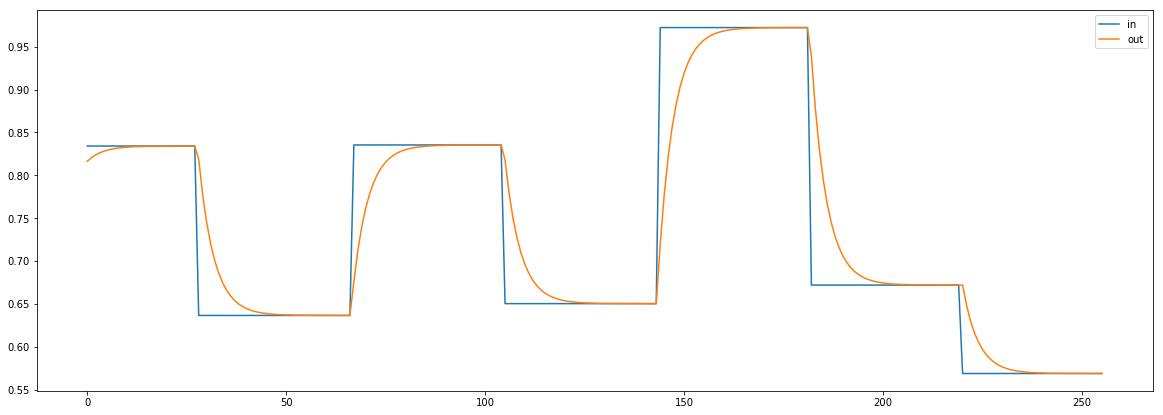

In [243]:
plt.plot(x[num_datapoints//6:num_datapoints//5], label = "in")
plt.plot(y[num_datapoints//6:num_datapoints//5], label = "out")
plt.legend()

Example of generating SIN wave of same len to werify model validity

In [244]:
#####################
# Set parameters
#####################

# Data params
noise_var = 0
num_datapoints = num_datapoints
test_size = 0.2
num_train = int((1-test_size) * num_datapoints)

# Network params
input_size = 30
# If `per_element` is True, then LSTM reads in one timestep at a time.
per_element = True
if per_element:
    lstm_input_size = 1
else:
    lstm_input_size = input_size
# size of hidden layers
h1 = 16
output_dim = 1
num_layers = 2
learning_rate = 1e-3
num_epochs = 5000
dtype = torch.float


In [245]:
x_batches = []
for i in range(1,input_size+1):
    x_batches.append(x[i:-(input_size+1-i)])
x = np.array(x_batches)
y = y[input_size:] # displacing

In [246]:
len(x_batches)

30

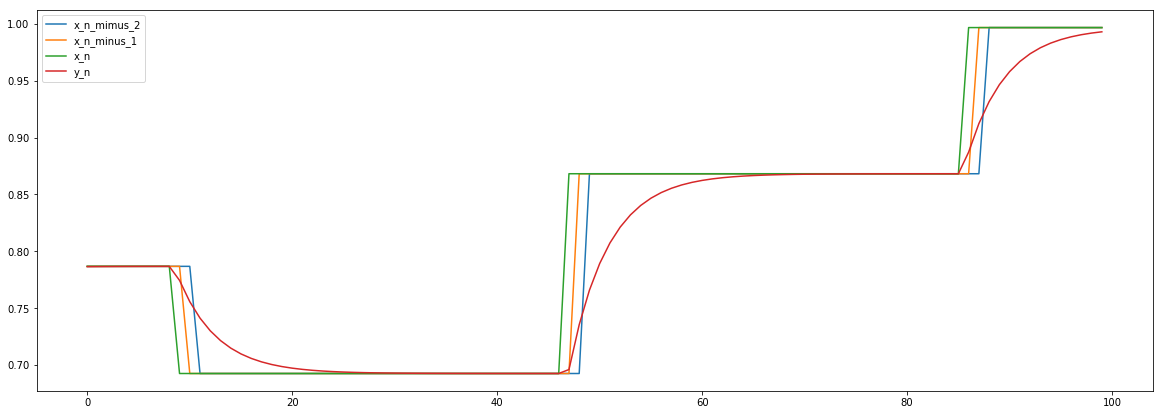

In [247]:
plt.plot(x[input_size-3][:100], label = 'x_n_mimus_2')
plt.plot(x[input_size-2][:100], label = 'x_n_minus_1')
plt.plot(x[input_size-1][:100], label = 'x_n')
plt.plot(y[:100], label='y_n')
plt.legend()

In [248]:
x.shape

(30, 7662, 1)

In [249]:
generate_data = False
#####################
# Generate data
#####################
if generate_data:
    from examples.generate_data import *
    data = ARData(num_datapoints,
                  num_prev=input_size,
                  test_size=test_size, 
                  noise_var=noise_var,
                  coeffs=fixed_ar_coefficients[input_size])

    # make training and test sets in torch
    X_train = torch.from_numpy(data.X_train).type(torch.Tensor)
    X_test = torch.from_numpy(data.X_test).type(torch.Tensor)
    y_train = torch.from_numpy(data.y_train).type(torch.Tensor).view(-1)
    y_test = torch.from_numpy(data.y_test).type(torch.Tensor).view(-1)

    X_train = X_train.view([input_size, -1, 1])
    X_test = X_test.view([input_size, -1, 1])
    plt.plot(data.X_train[:20, 12], label = '12')
    plt.plot(data.X_train[:20, 16], label = '16')
    plt.plot(data.X_train[:20, 19], label = '19')
    plt.plot(data.y_train[:20], label = 'out')

    plt.legend()

In [250]:
X_train = torch.from_numpy(x[:, :num_train]).type(torch.Tensor)
# X_test = torch.from_numpy(x[:, num_train:]).type(torch.Tensor)
X_train = X_train.view([input_size, -1, 1])
# X_test = X_test.view([input_size, -1, 1])
y_train = torch.from_numpy(y[:num_train, :]).type(torch.Tensor).view(-1)
# y_test = torch.from_numpy(y[num_train:, :]).type(torch.Tensor).view(-1)

In [251]:
tst = np.zeros_like(x[:, :num_train])
tst[:,:x.shape[1] - num_train].shape
tst[:,:x.shape[1] - num_train] += x[:, num_train:]
X_test = torch.from_numpy(tst).type(torch.Tensor)
X_test = X_test.view([input_size, -1, 1])
y_tst = np.zeros_like(y[:num_train, :])
y_tst[:y.shape[0] - num_train, :] = y[num_train:, :]
y_test = torch.from_numpy(y_tst).type(torch.Tensor).view(-1)

In [252]:
X_train.shape

torch.Size([30, 6146, 1])

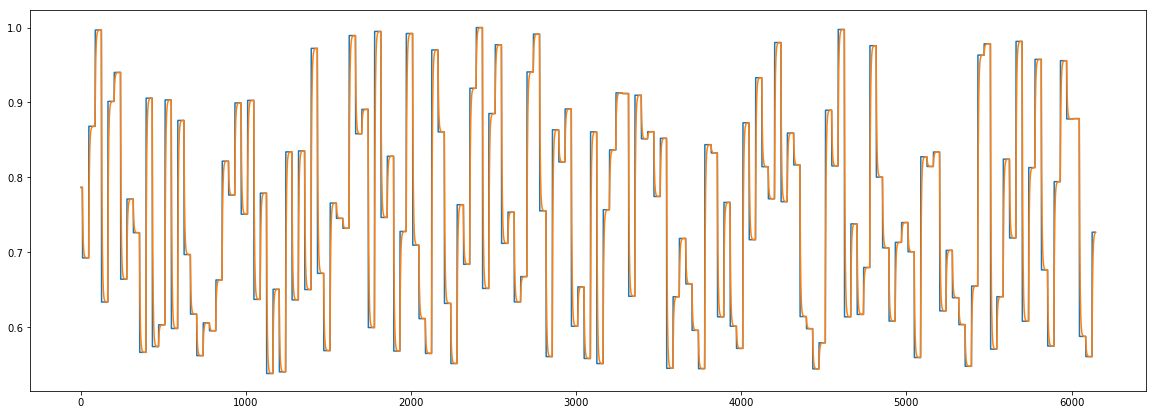

In [253]:
plt.plot(X_train.detach().numpy()[input_size-2])
plt.plot(y_train.detach().numpy())

In [254]:
def plot_multiscale(data, colors):
    fig, ax = plt.subplots()
    # Twin the x-axis twice to make independent y-axes.
    axes = [ax]
    if len(data) > 1:
        for i in range(len(data)-1):
            axes.append(ax.twinx())
    
    
    for ax, d, c in zip(axes, data, colors):
        ax.plot(d, color=c)
    plt.show()

In [255]:

#####################
# Build model
#####################

# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        # Only take the output from the final timestep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)
    

model = LSTM(lstm_input_size,
             h1,
             batch_size=num_train,
             output_dim=output_dim,
             num_layers=num_layers)

loss_fn = torch.nn.MSELoss(reduction="sum")

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [256]:
print(output_dim)

1


In [257]:
train_to_test_ratio = num_train / (num_datapoints - num_train)
train_to_test_ratio

3.9986987638256344

Epoch  0 MSE:  4292.65771484375


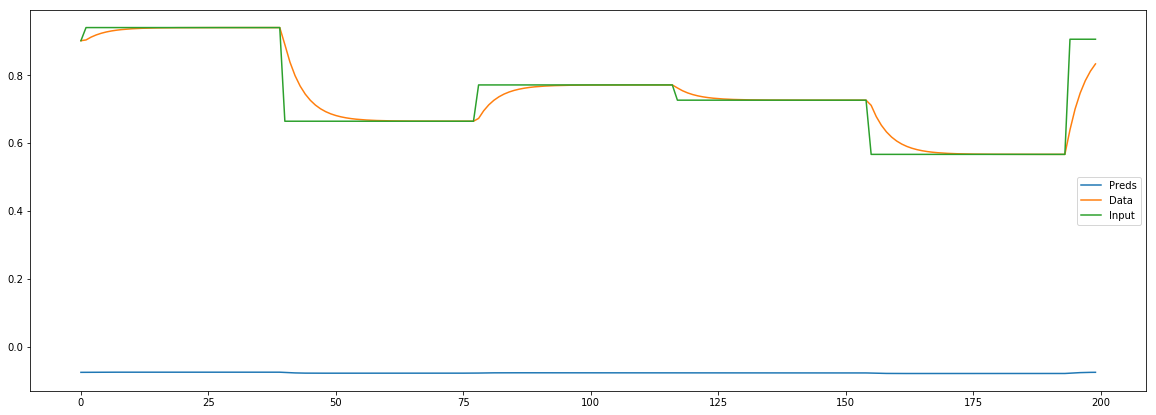

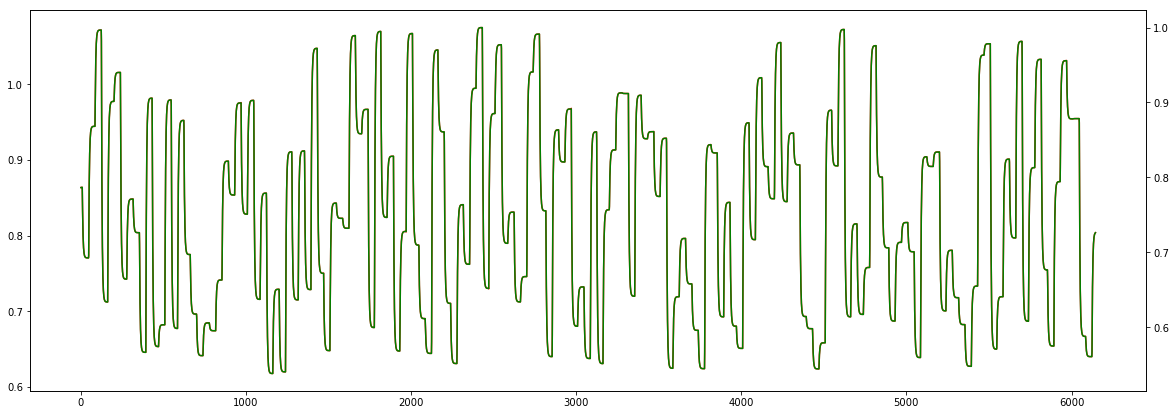

Epoch  0 MSE:  4465.303271420838


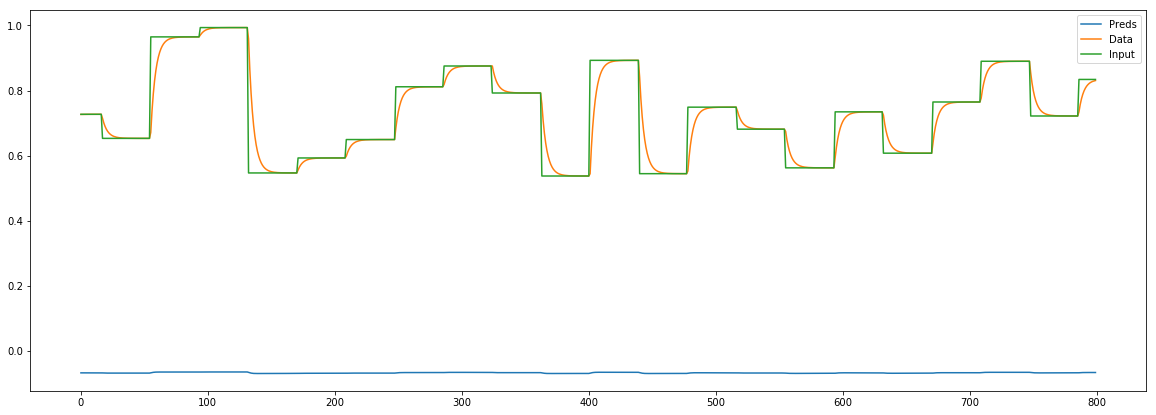

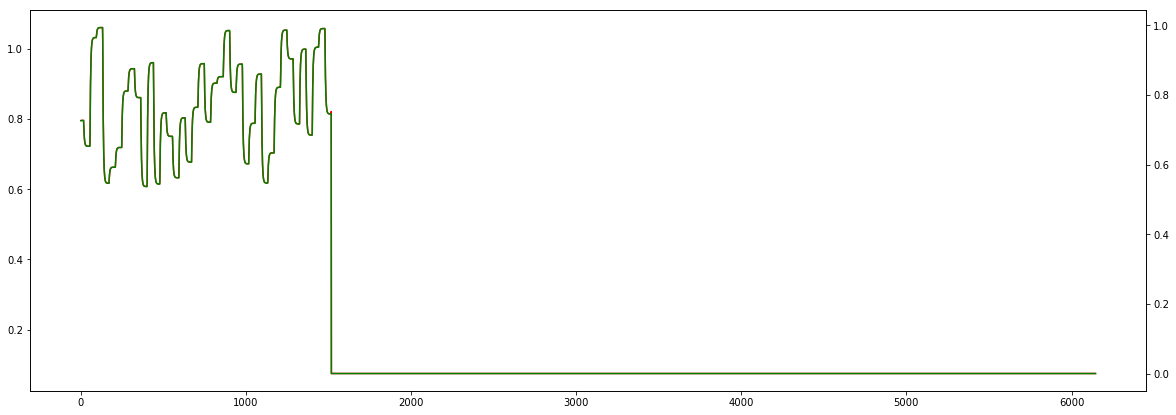

Epoch  100 MSE:  97.36965942382812


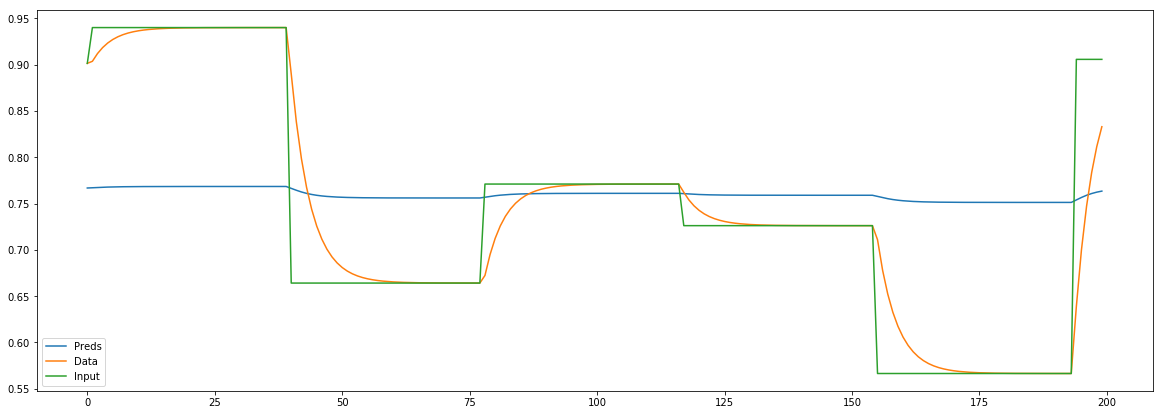

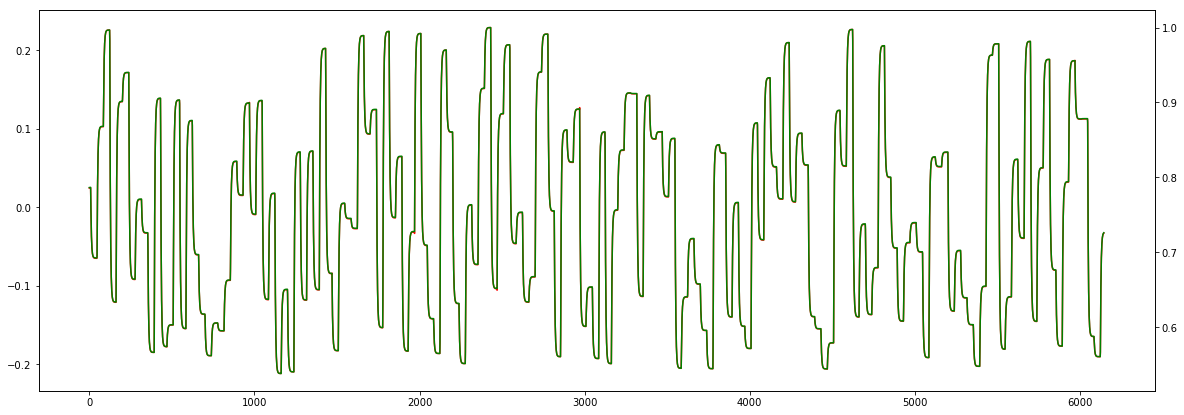

In [ ]:
#####################
# Train model
#####################

model.hidden = model.init_hidden()
hist = {"train_loss":np.zeros(num_epochs), "test_loss":np.zeros(num_epochs)}

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
        
        plt.plot(y_pred[200:400].detach().numpy(), label="Preds")
        plt.plot(y_train[200:400].detach().numpy(), label="Data")
        plt.plot(X_train[input_size-1][200:400].detach().numpy(), label="Input")
        plt.legend()
        plt.show()
        residuals = y_train-y_pred
        plot_multiscale(data=[residuals.detach().numpy(), y_train.detach().numpy()], 
               colors = ["Red", "Green"])
        
            
    hist['train_loss'][t] = loss.item()
    

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()
        
    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()
    
    
    # validate during evaluation
    with torch.no_grad():
        model = model.eval()
        y_pred_test = model(X_test)
        loss = loss_fn(y_pred_test, y_test)
        residuals = y_test-y_pred_test
        hist['test_loss'][t] = loss.item() * train_to_test_ratio
        model = model.train()
        if t % 300 == 0:
            print("Epoch ", t, "MSE: ", loss.item() * train_to_test_ratio)
            plt.plot(y_pred_test[0:800].detach().numpy(), label="Preds")
            plt.plot(y_test[0:800].detach().numpy(), label="Data")
            plt.plot(X_test[input_size-1][0:800].detach().numpy(), label="Input")
            plt.legend()
            plt.show()
            plot_multiscale(data=[residuals.detach().numpy(), y_test.detach().numpy()], 
                   colors = ["Red", "Green"])


In [ ]:
plt.plot(hist['train_loss'])

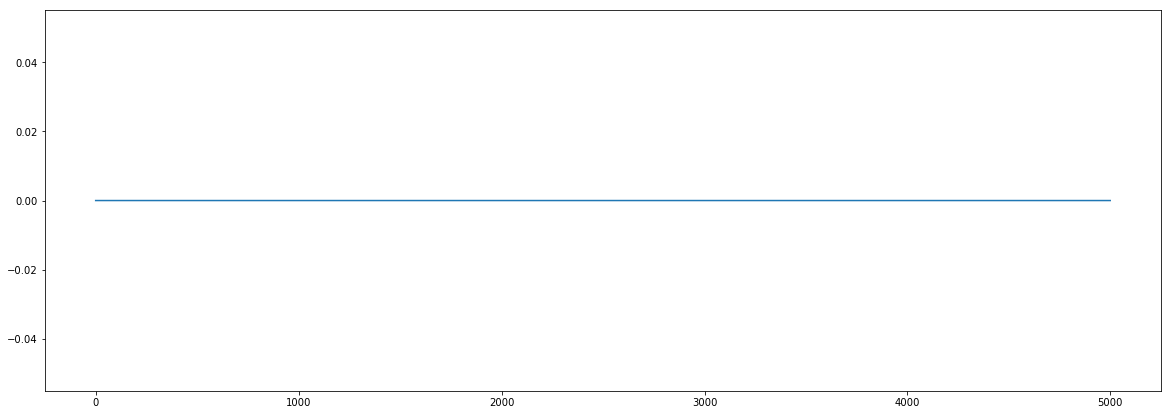

In [220]:
plt.plot(hist['test_loss'])

In [ ]:
#

In [86]:
while True:
    pass #piece of code preventing from overwriting previous results

KeyboardInterrupt: 

## Previouse value for comparison

Epoch  0 MSE:  5544.6943359375


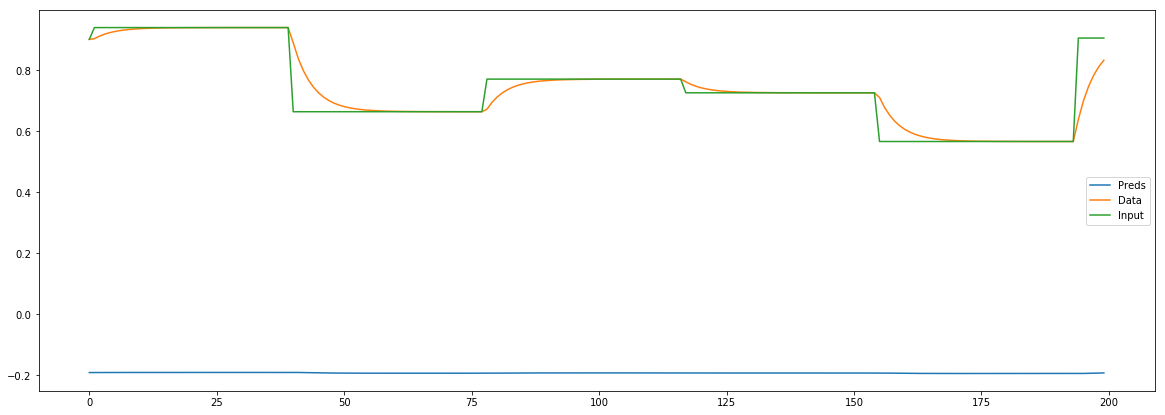

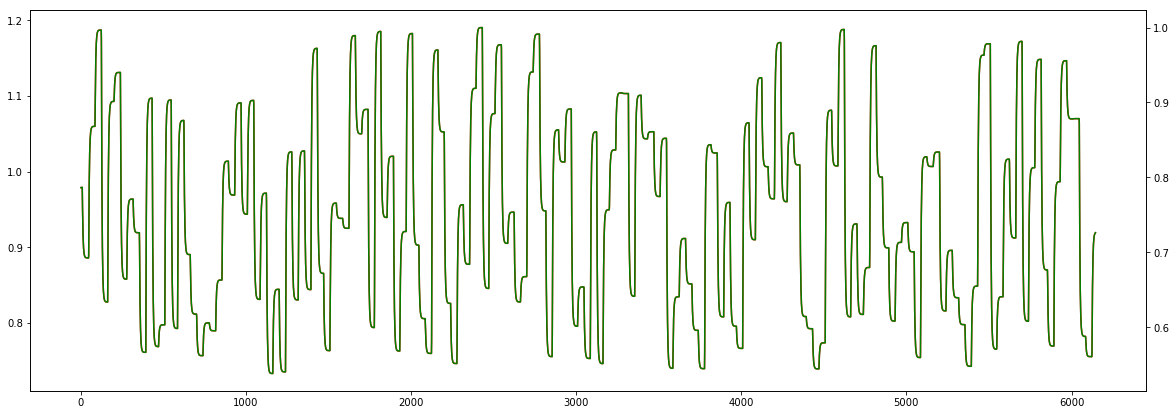

Epoch  100 MSE:  86.67247009277344


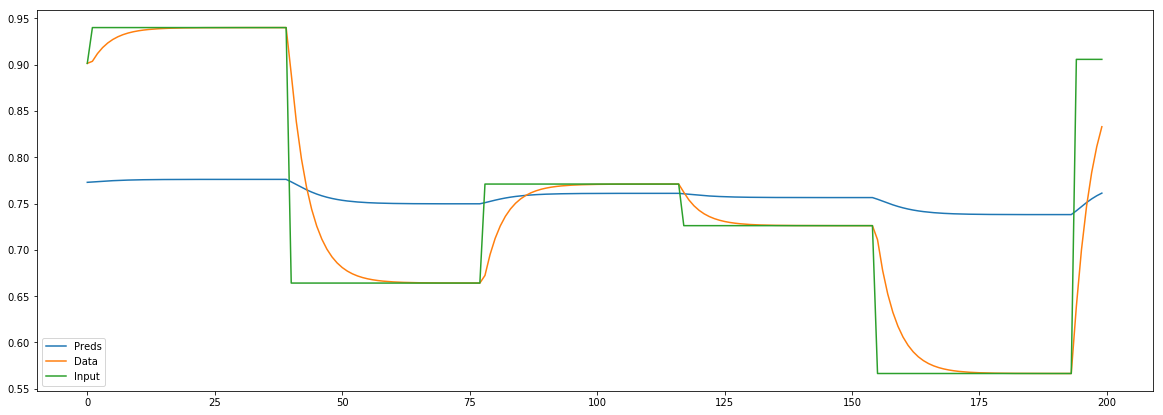

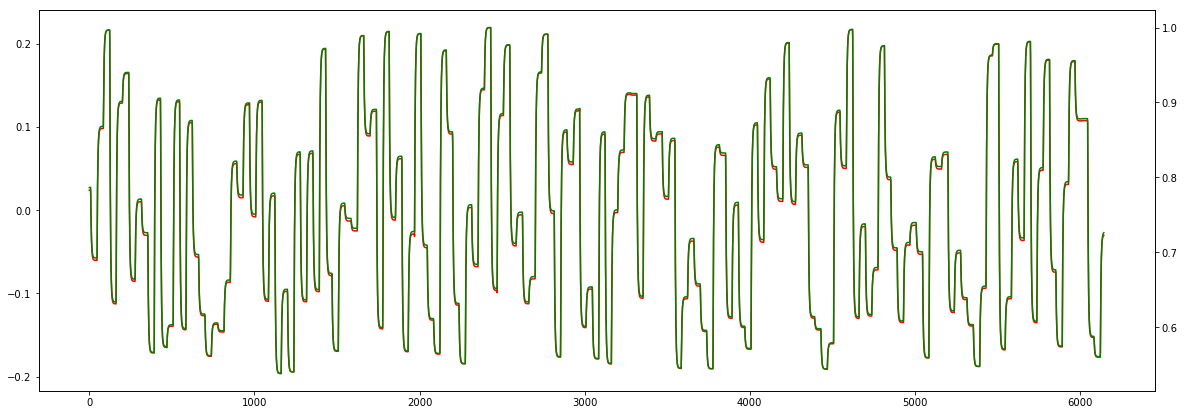

Epoch  200 MSE:  69.5999526977539


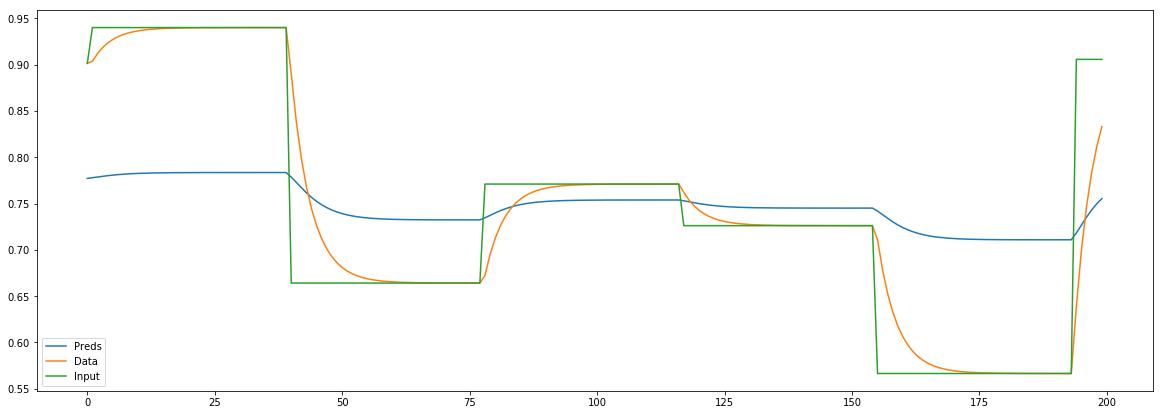

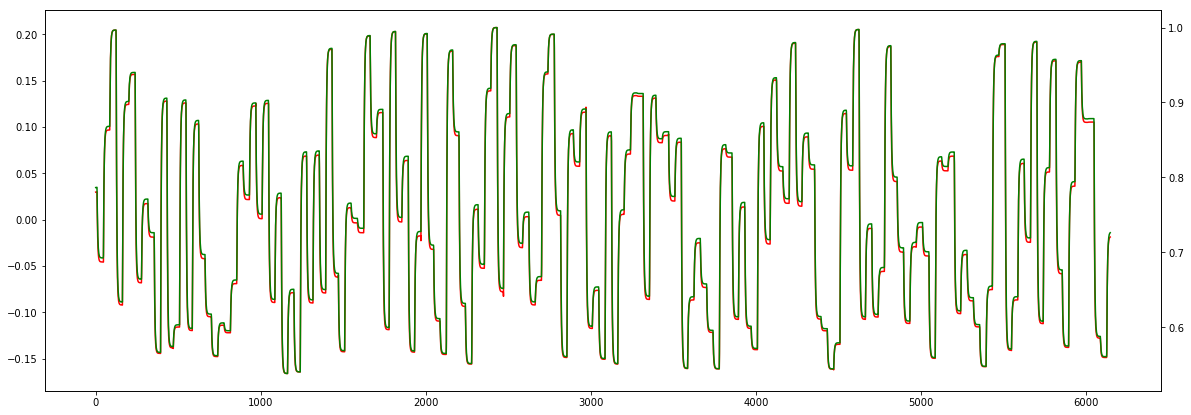

Epoch  300 MSE:  24.327442169189453


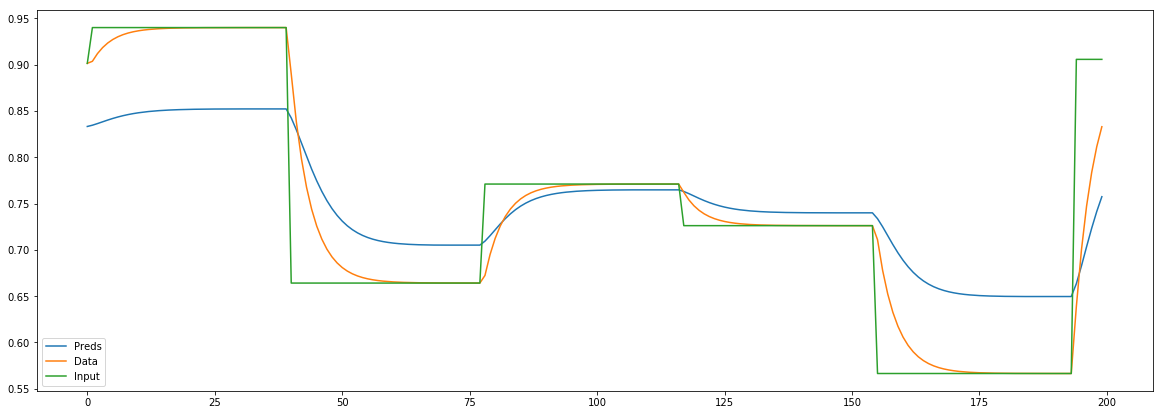

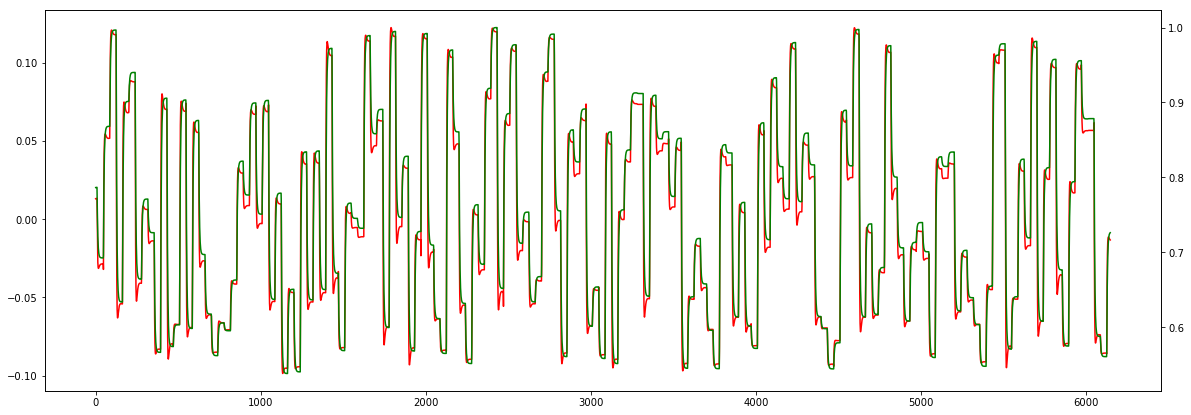

Epoch  400 MSE:  2.637904405593872


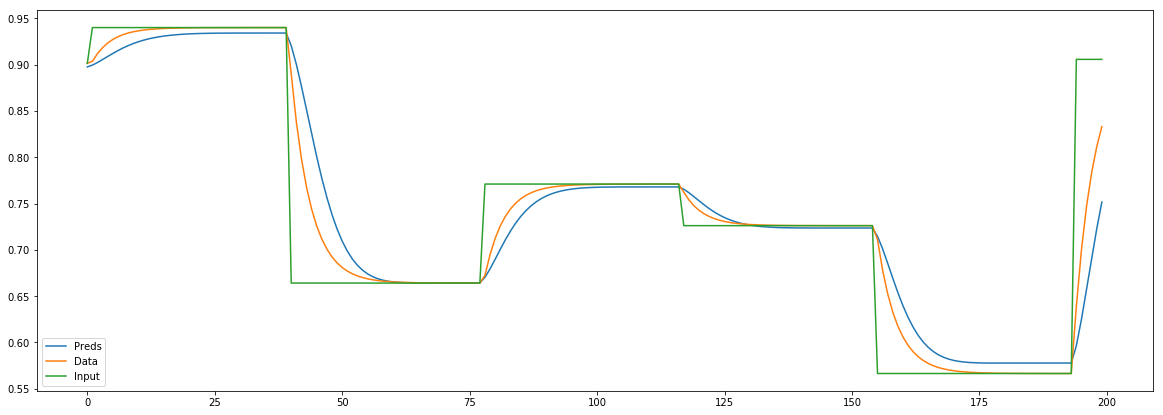

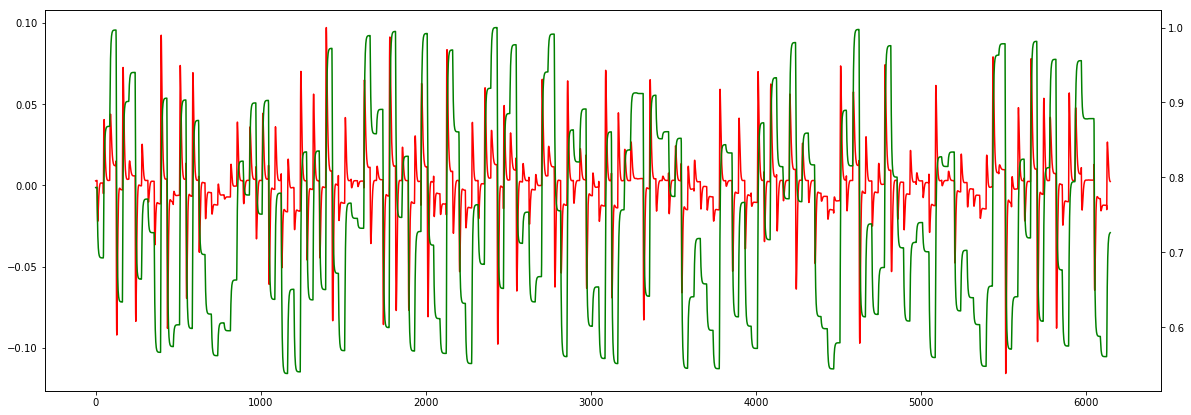

Epoch  500 MSE:  1.0771676301956177


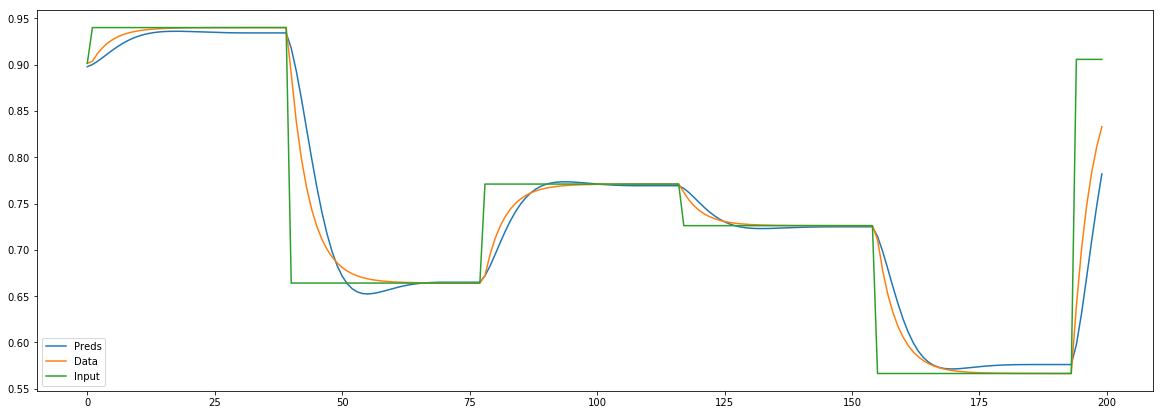

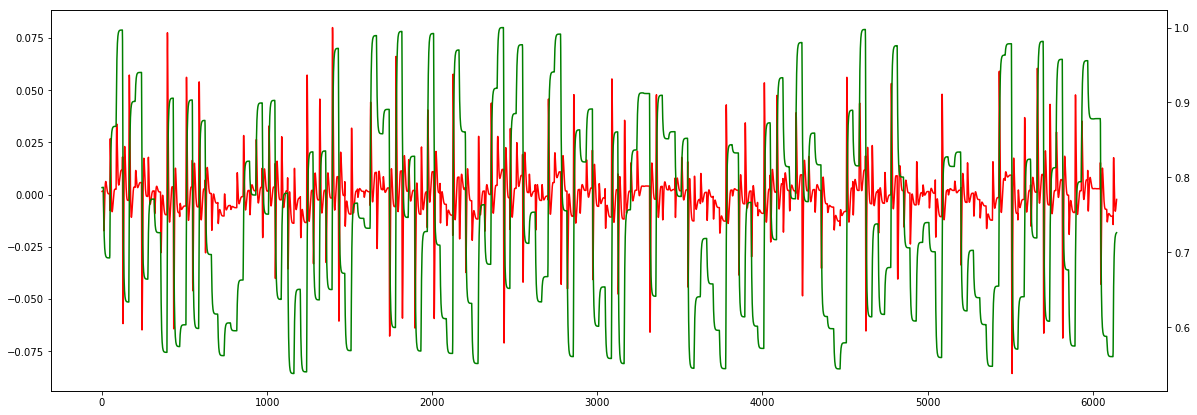

Epoch  600 MSE:  0.824261486530304


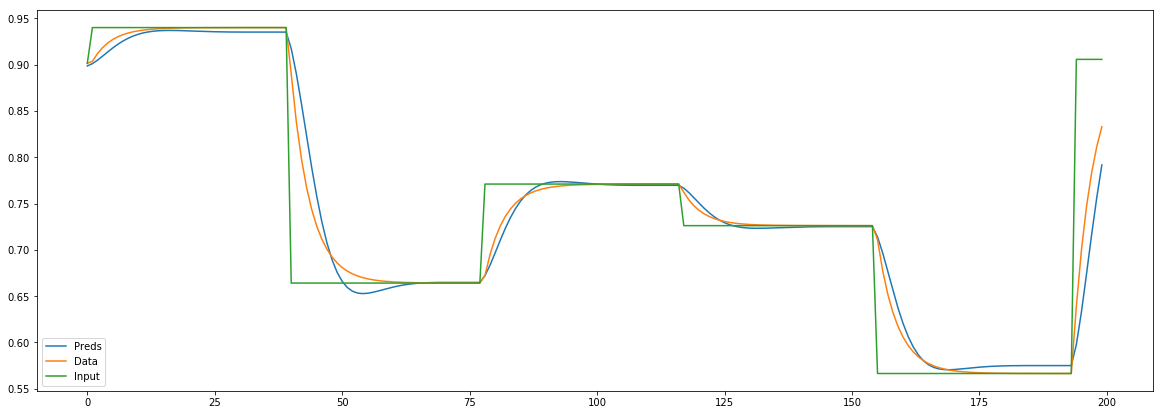

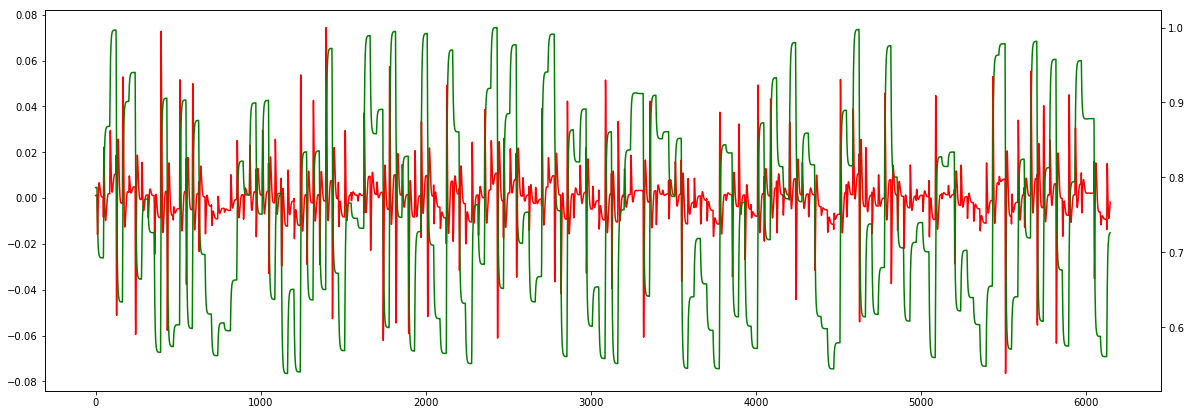

Epoch  700 MSE:  0.6582345366477966


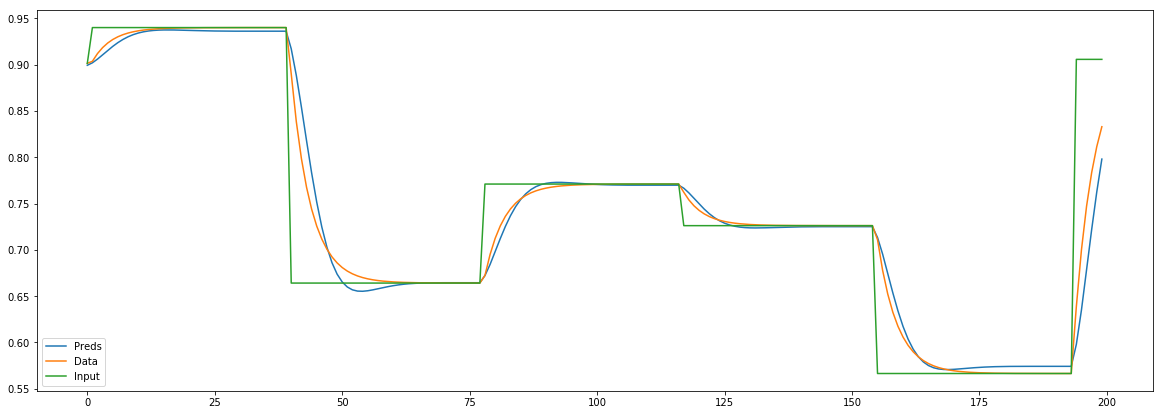

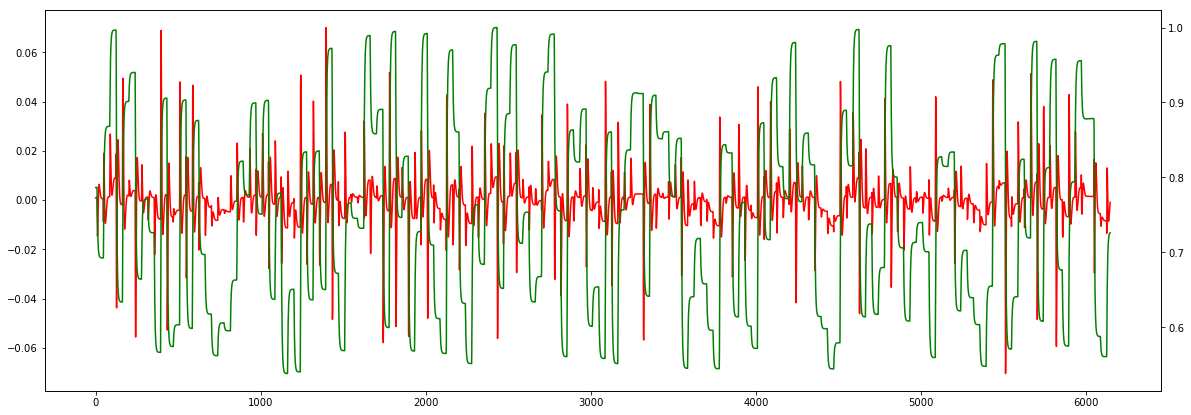

Epoch  800 MSE:  0.539267897605896


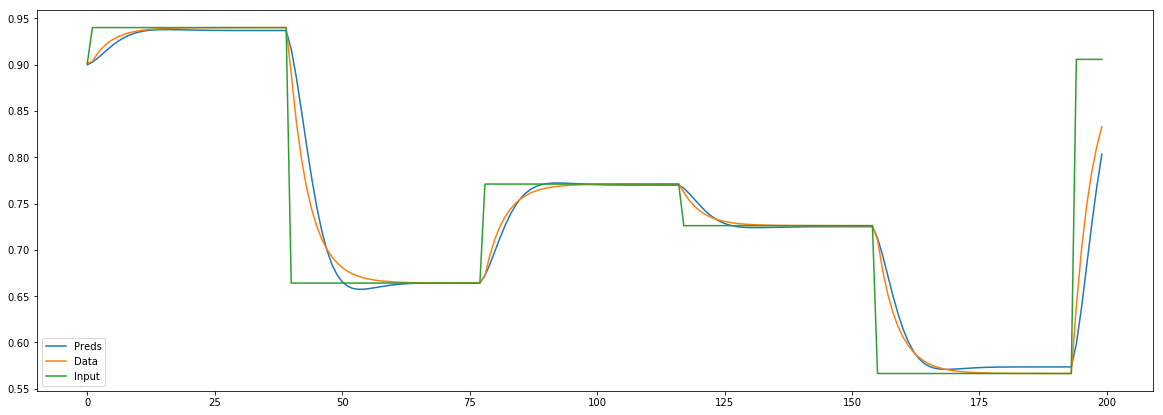

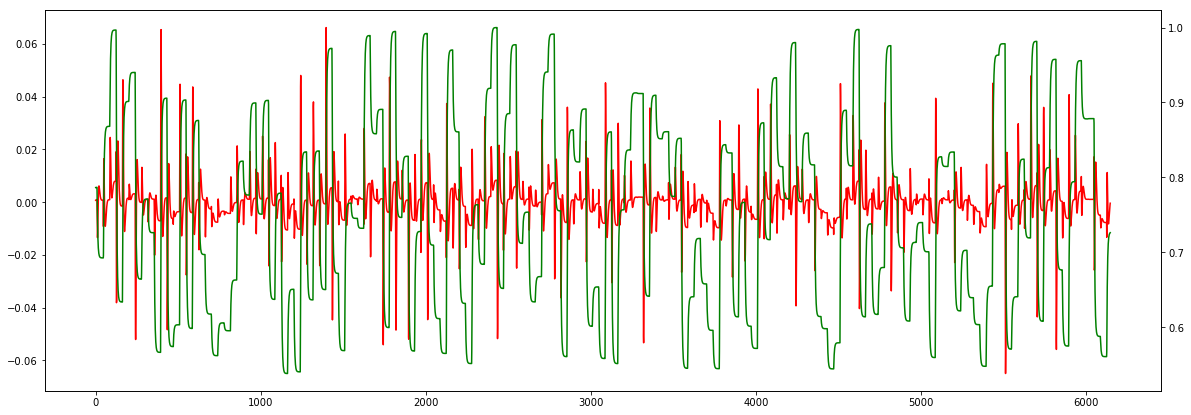

Epoch  900 MSE:  0.45096632838249207


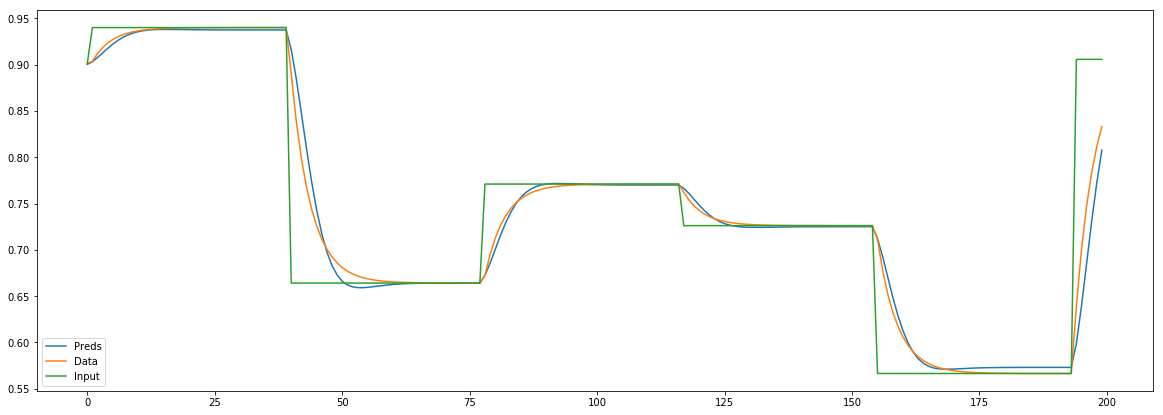

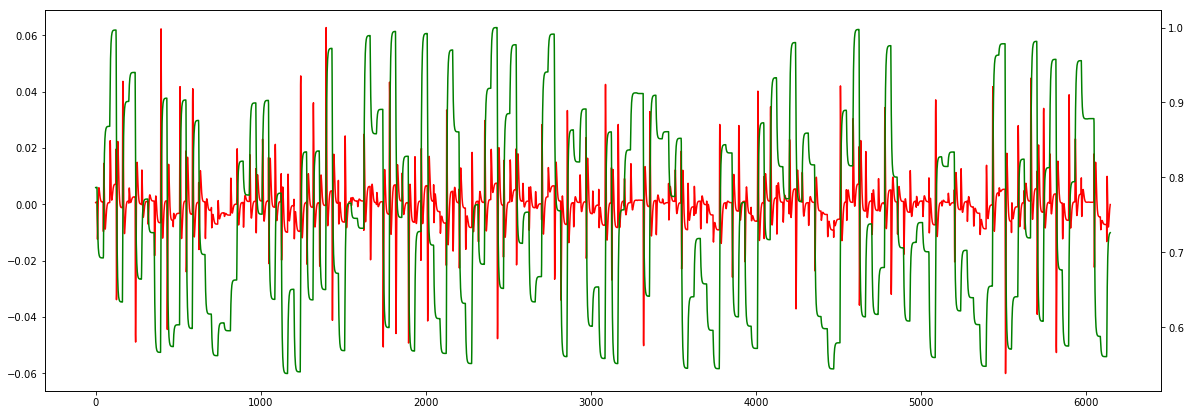

Epoch  1000 MSE:  0.383255273103714


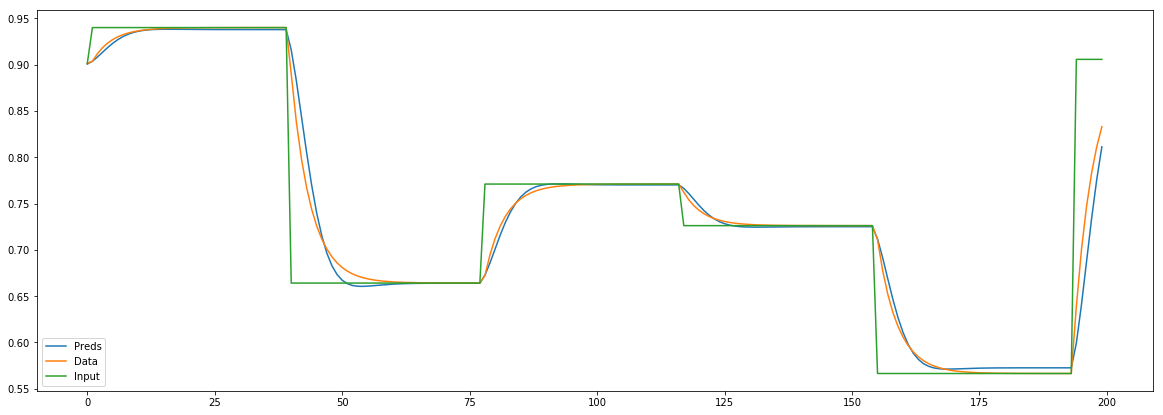

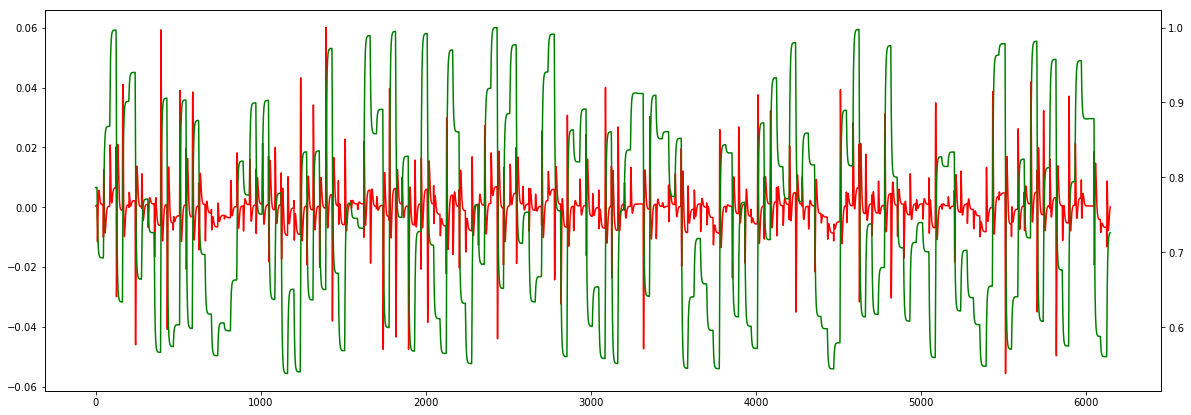

Epoch  1100 MSE:  0.32976314425468445


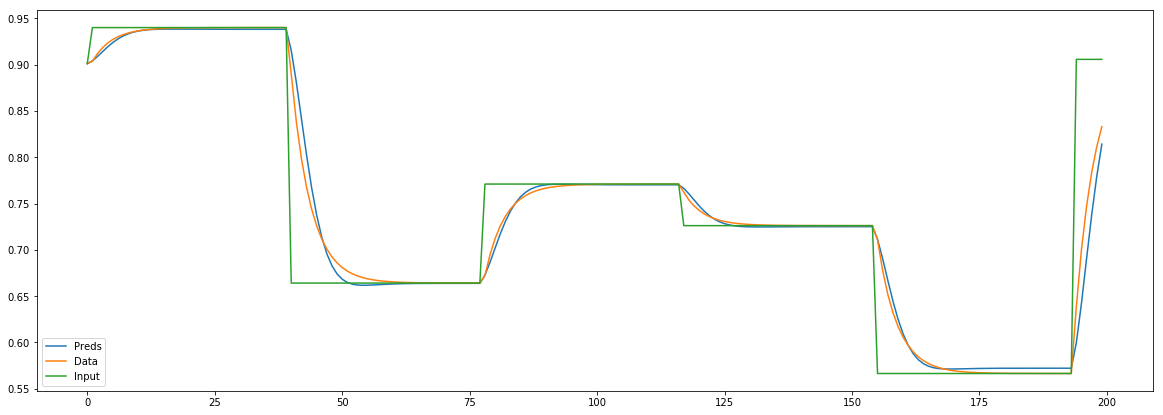

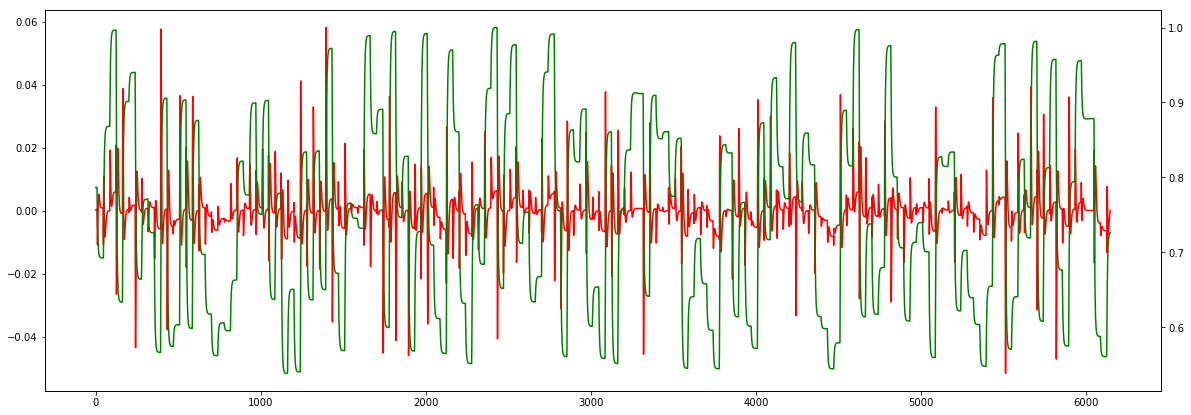

Epoch  1200 MSE:  0.2863965630531311


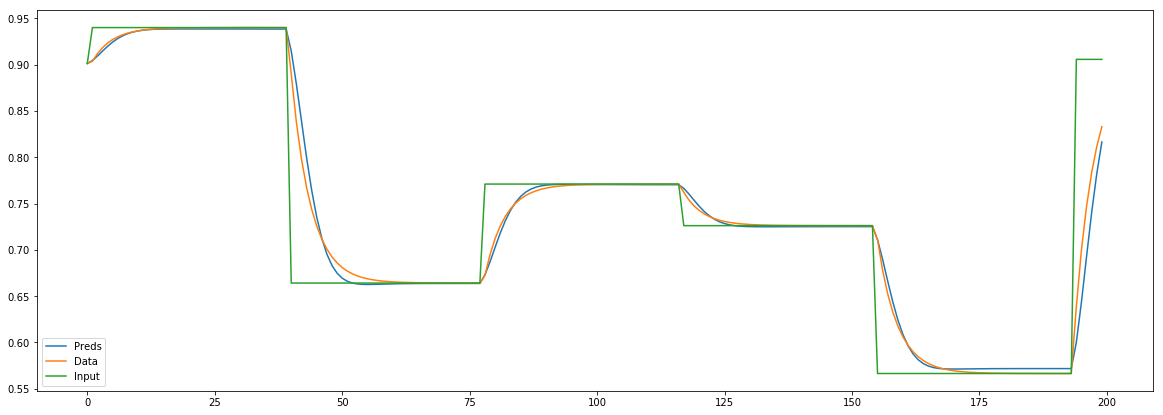

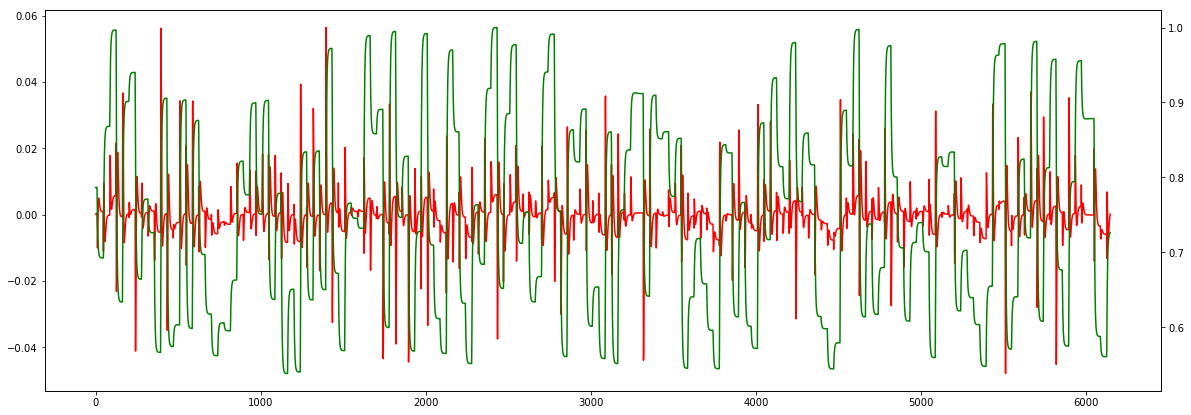

Epoch  1300 MSE:  0.2504793107509613


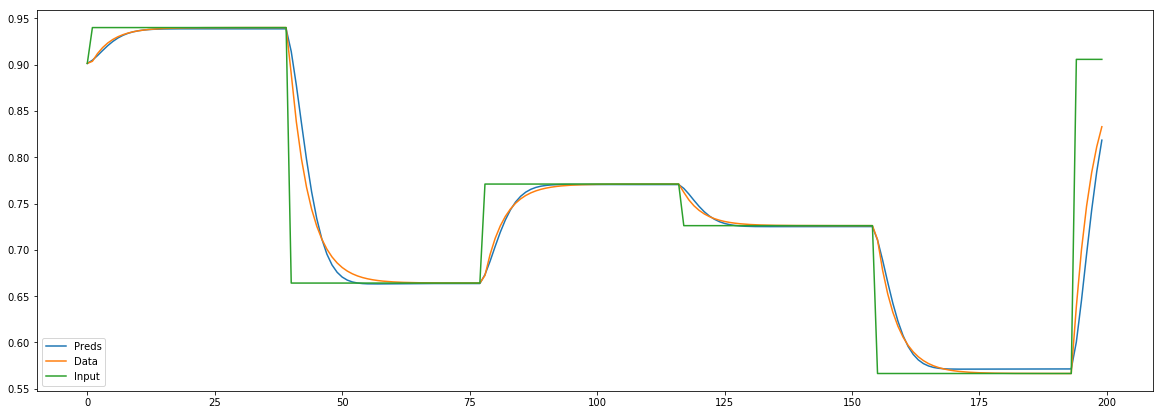

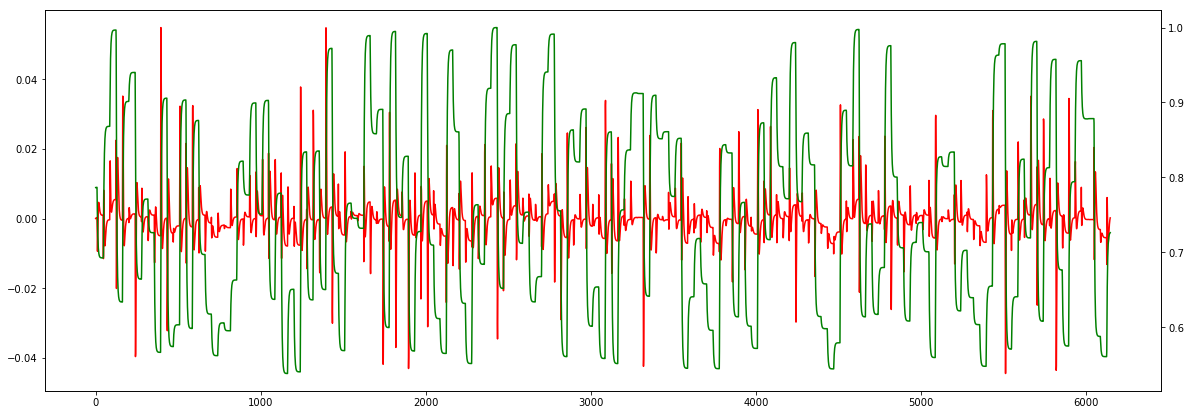

Epoch  1400 MSE:  0.22023361921310425


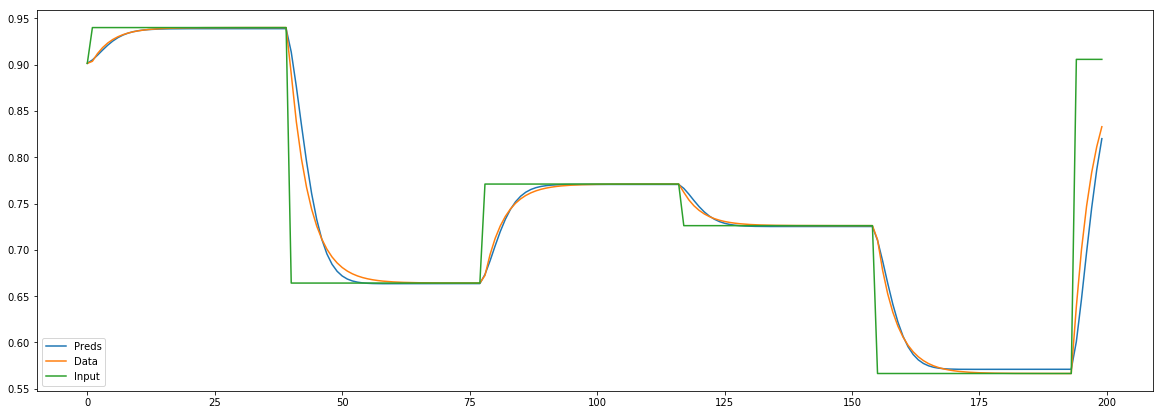

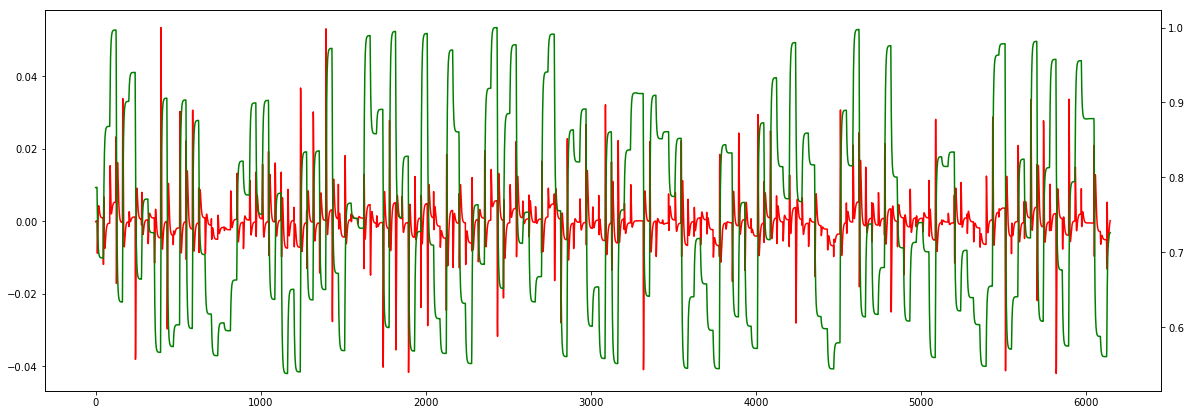

Epoch  1500 MSE:  0.1944684386253357


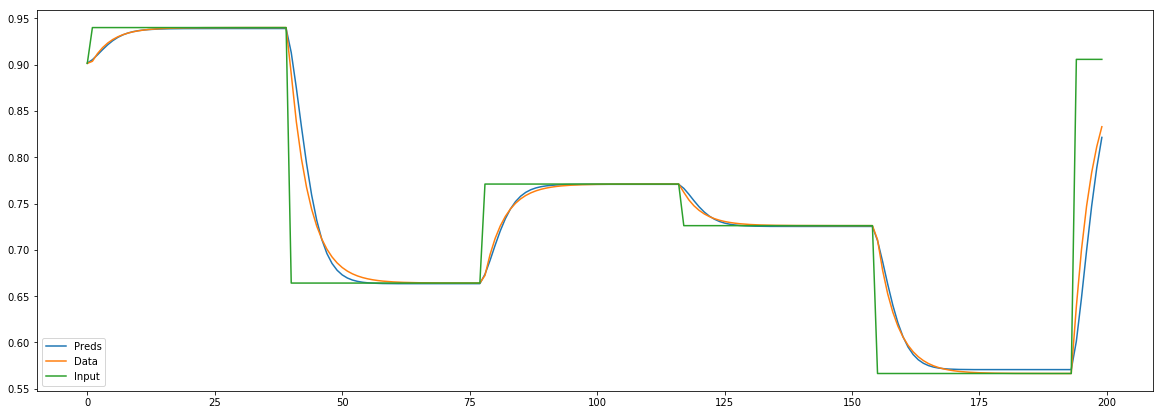

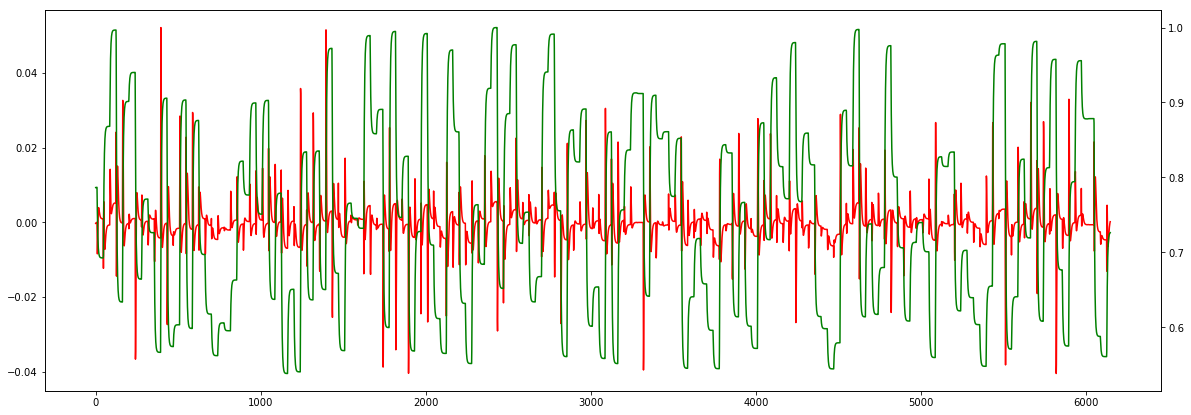

Epoch  1600 MSE:  0.17239150404930115


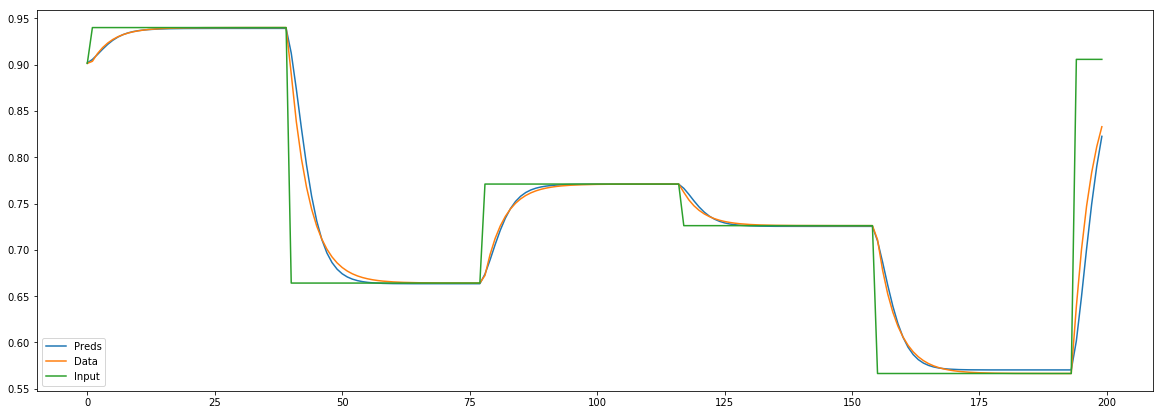

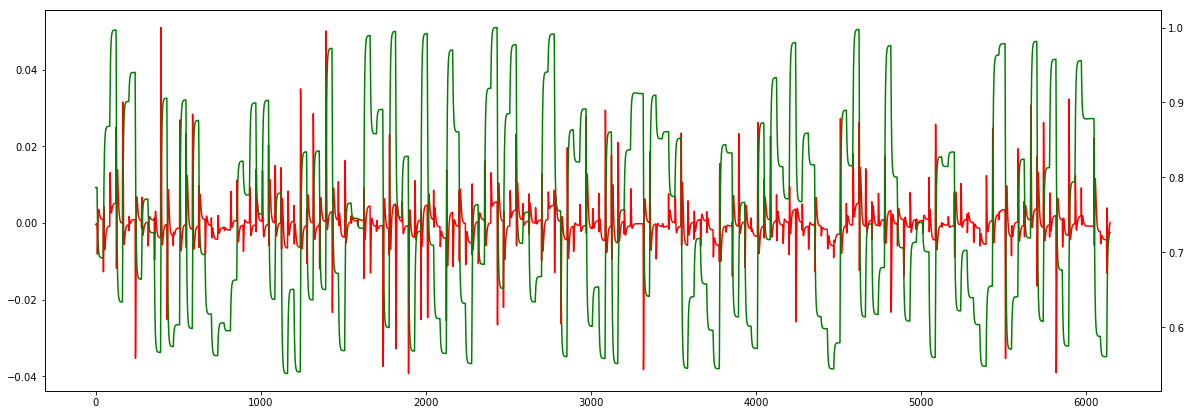

Epoch  1700 MSE:  0.15349151194095612


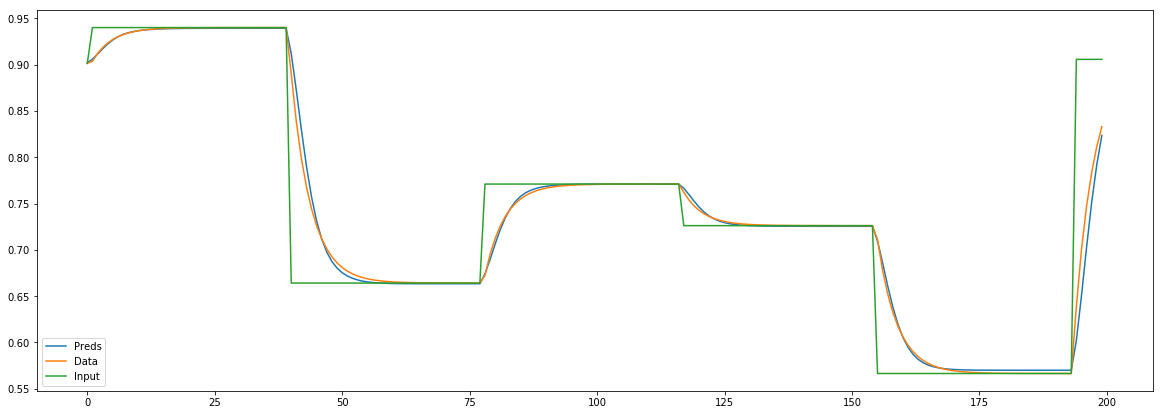

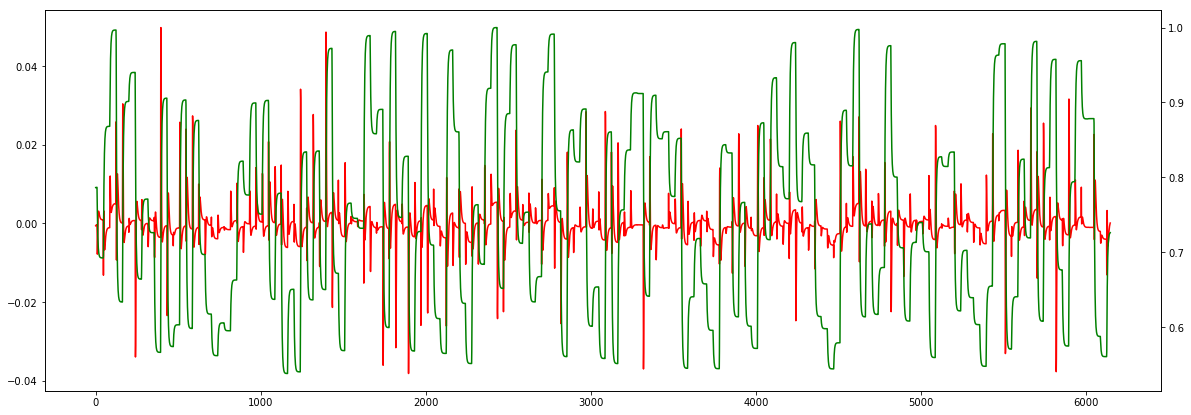

Epoch  1800 MSE:  0.1374506801366806


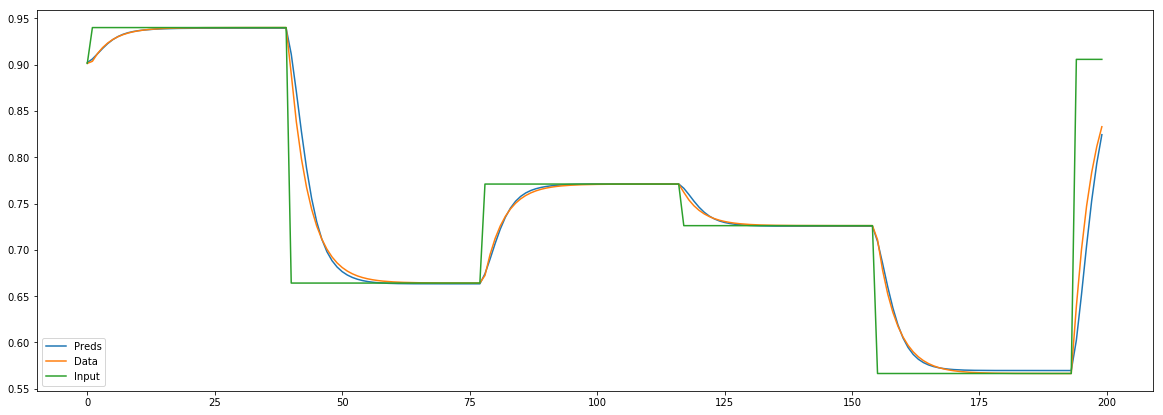

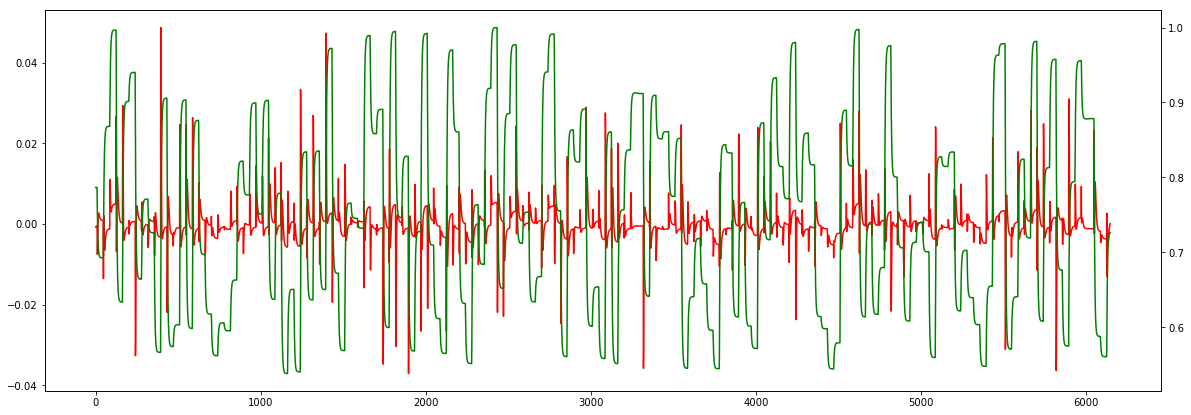

Epoch  1900 MSE:  0.12539899349212646


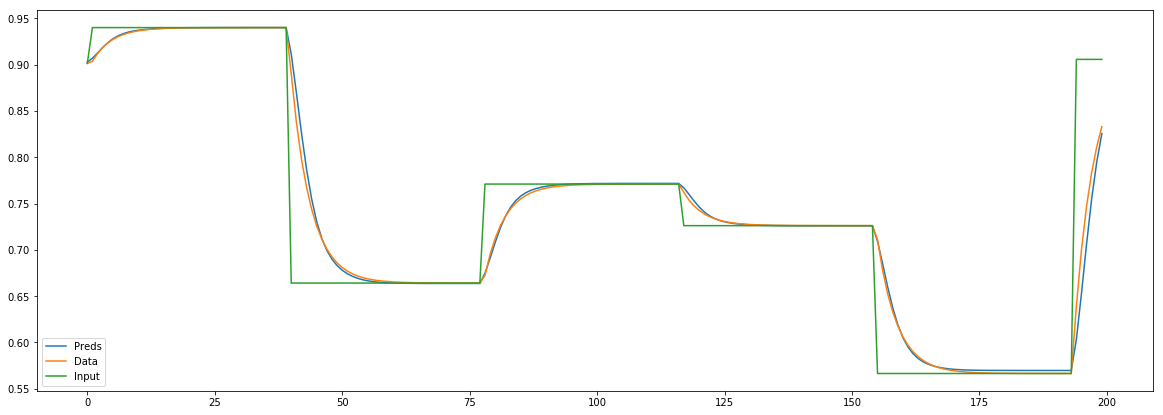

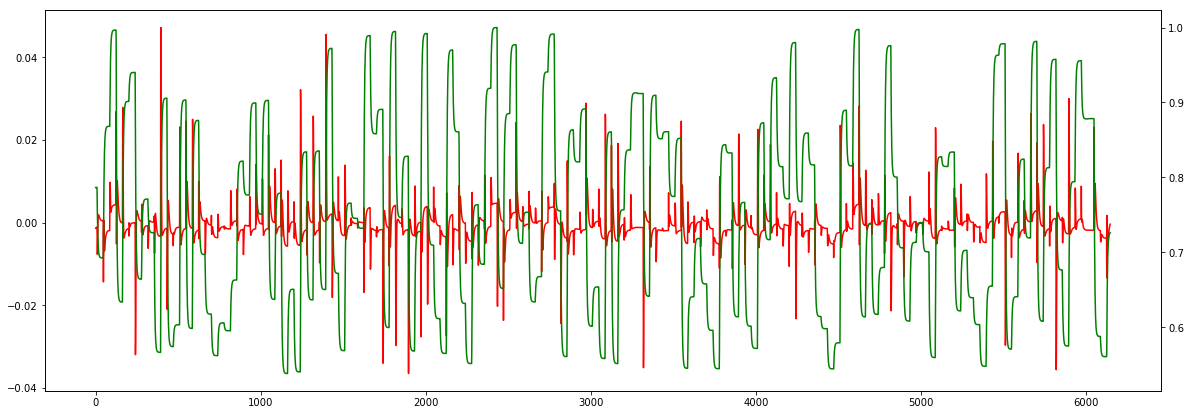

Epoch  2000 MSE:  0.11356037110090256


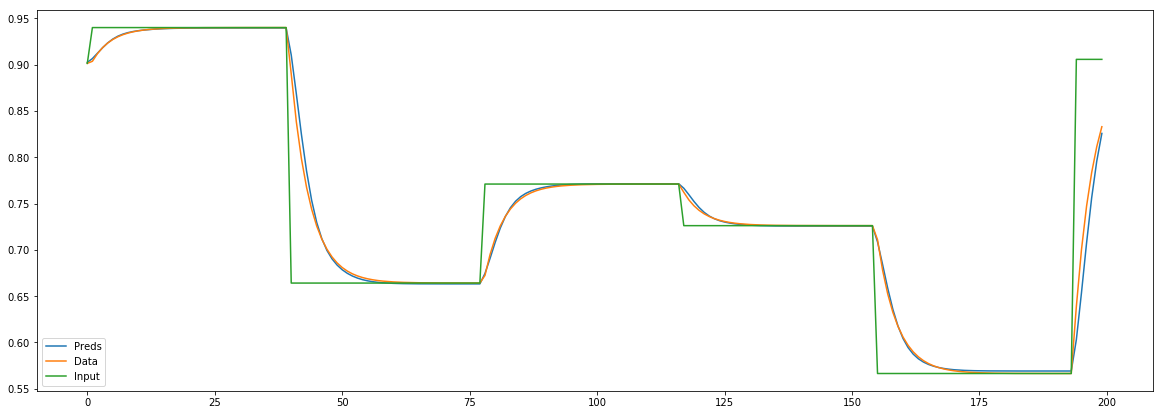

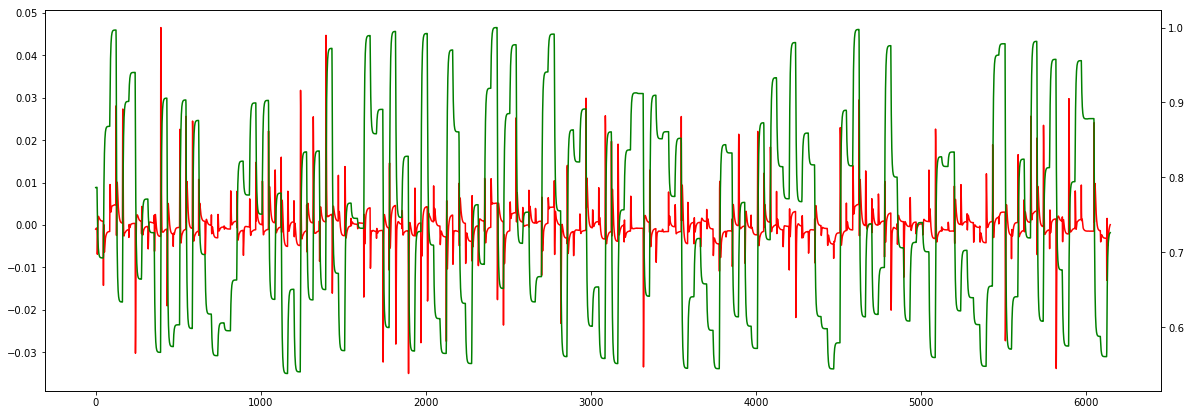

Epoch  2100 MSE:  0.10525431483983994


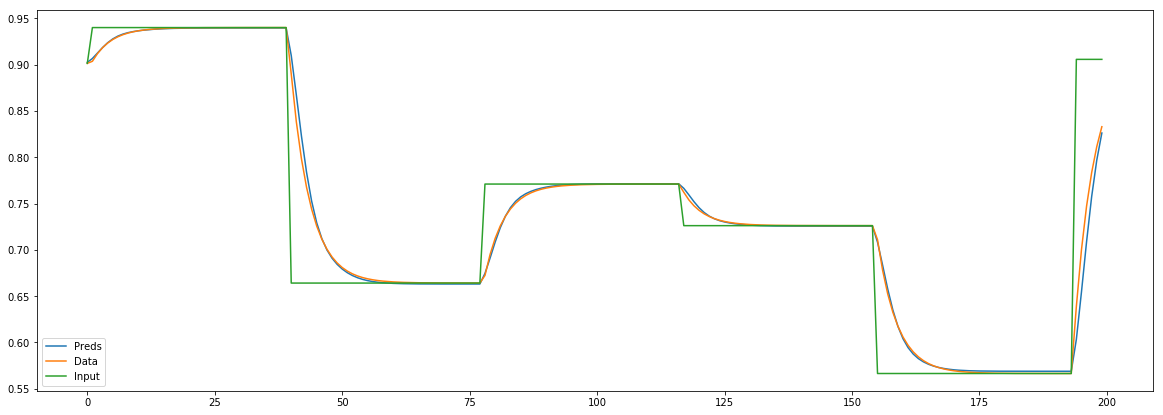

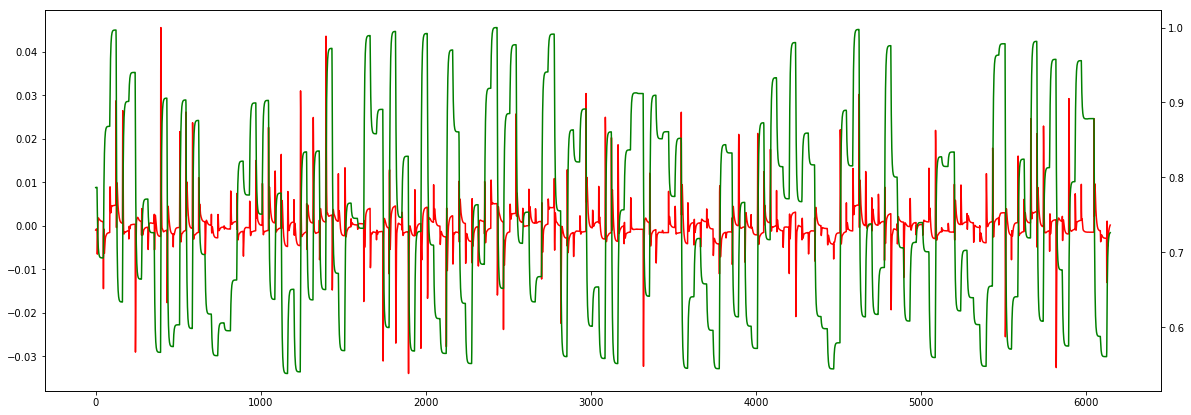

Epoch  2200 MSE:  0.09873014688491821


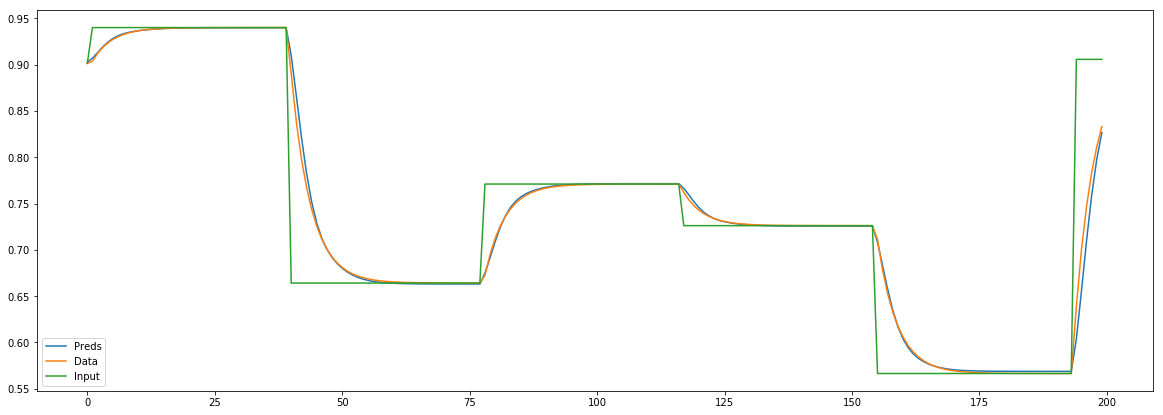

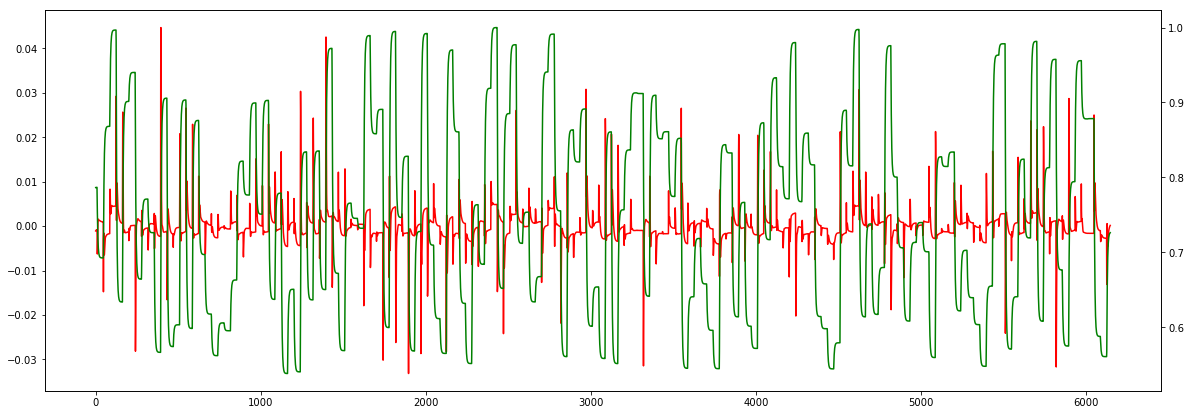

Epoch  2300 MSE:  0.09384029358625412


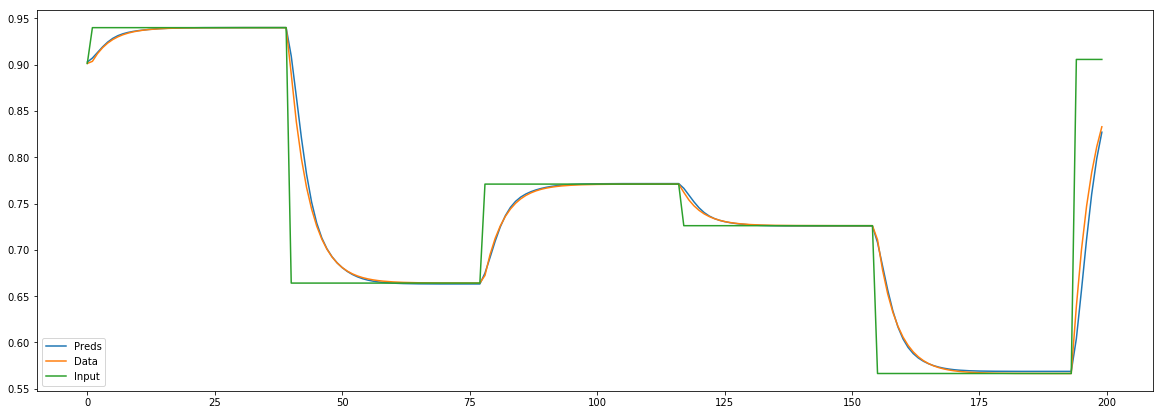

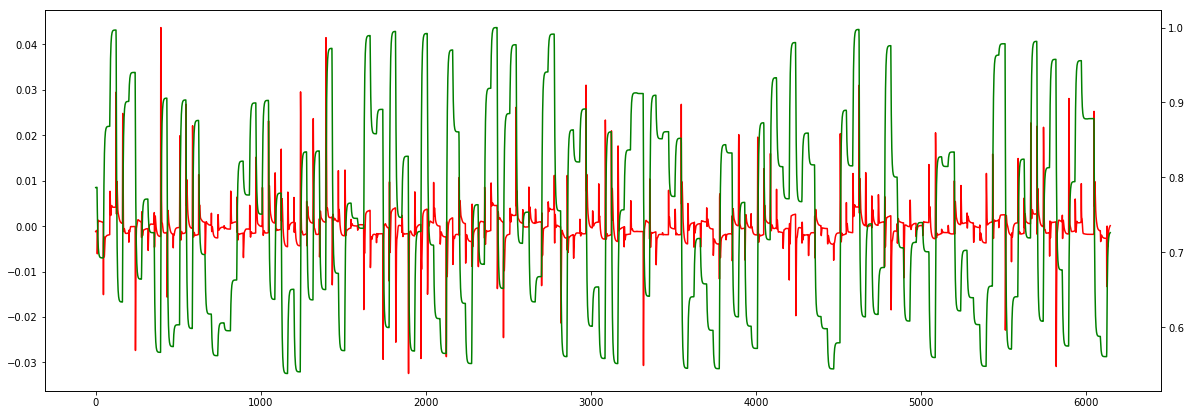

Epoch  2400 MSE:  0.08994293212890625


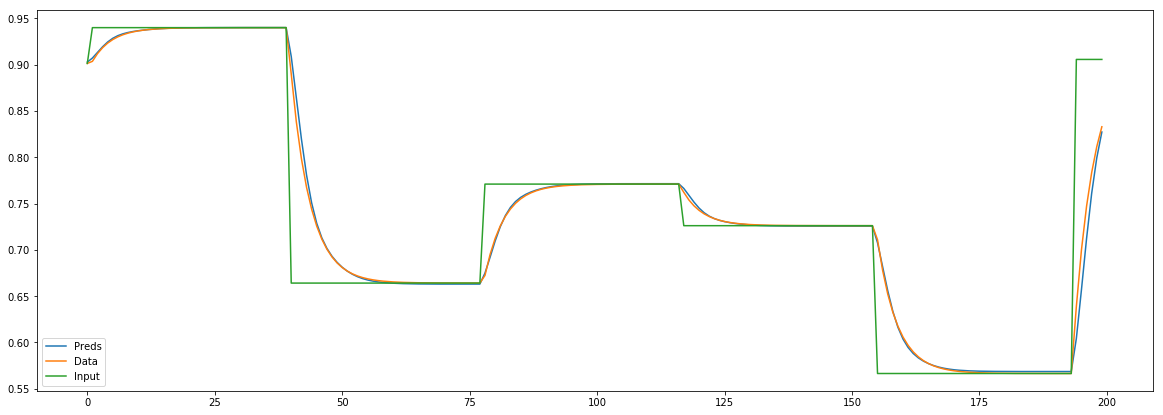

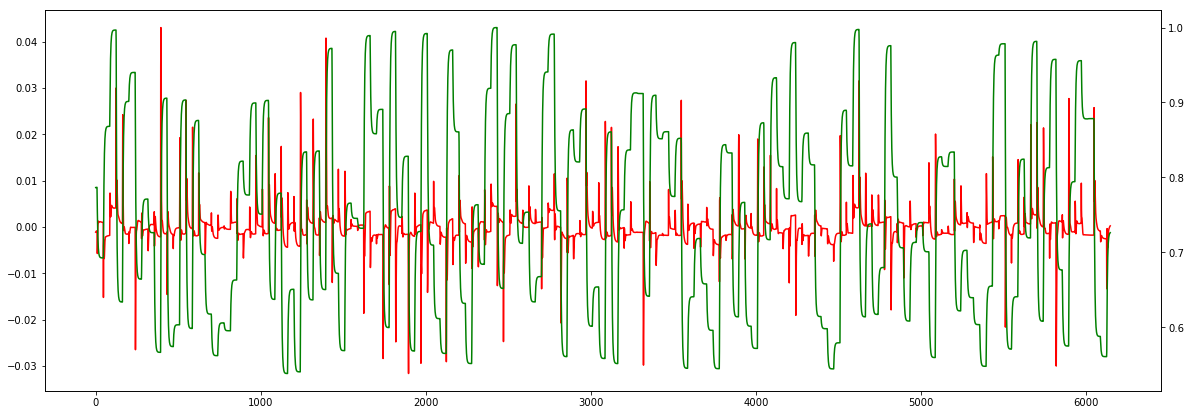

Epoch  2500 MSE:  0.08709955215454102


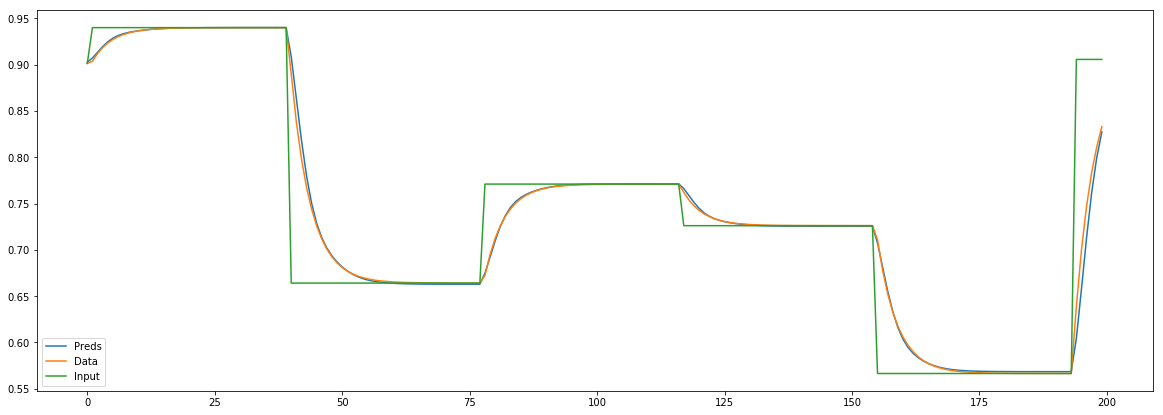

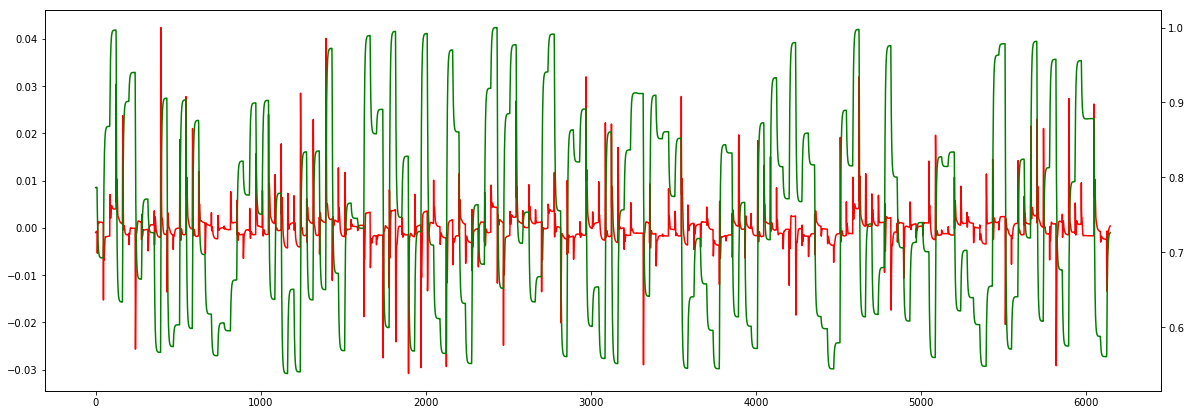

Epoch  2600 MSE:  0.08472918719053268


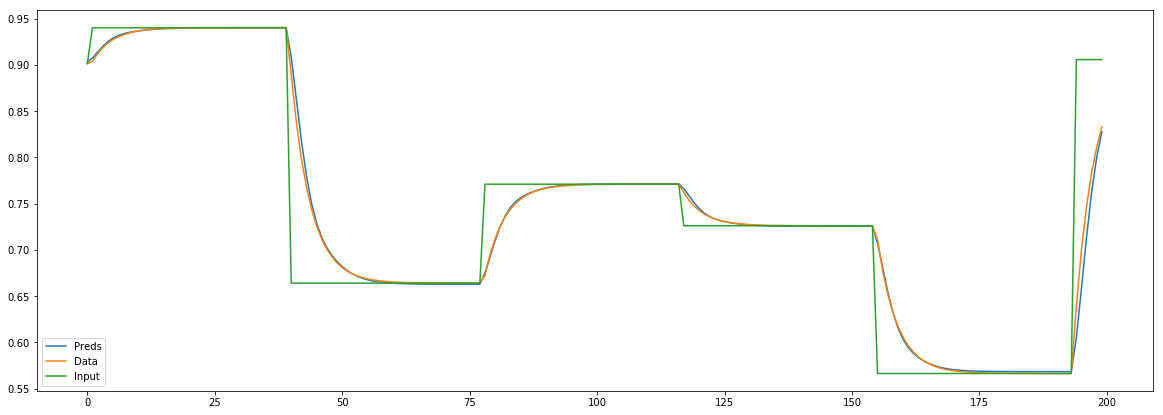

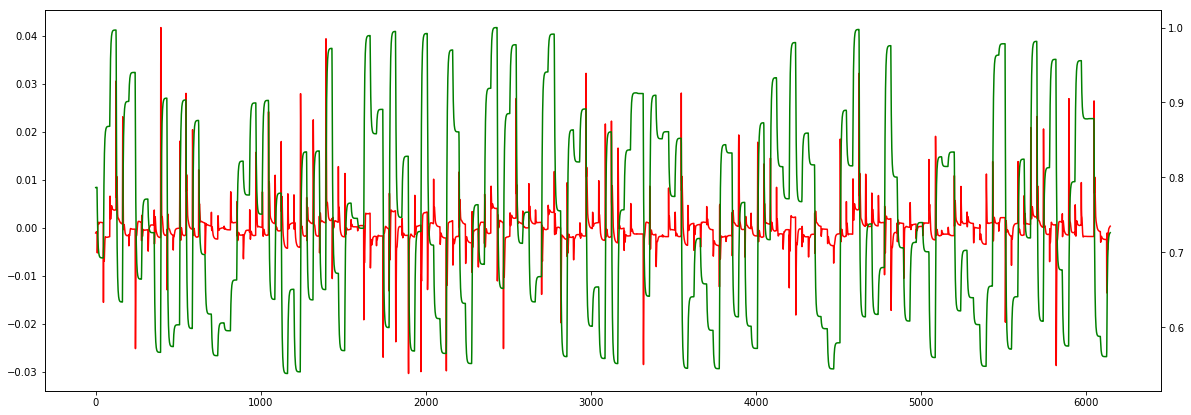

Epoch  2700 MSE:  0.08362574875354767


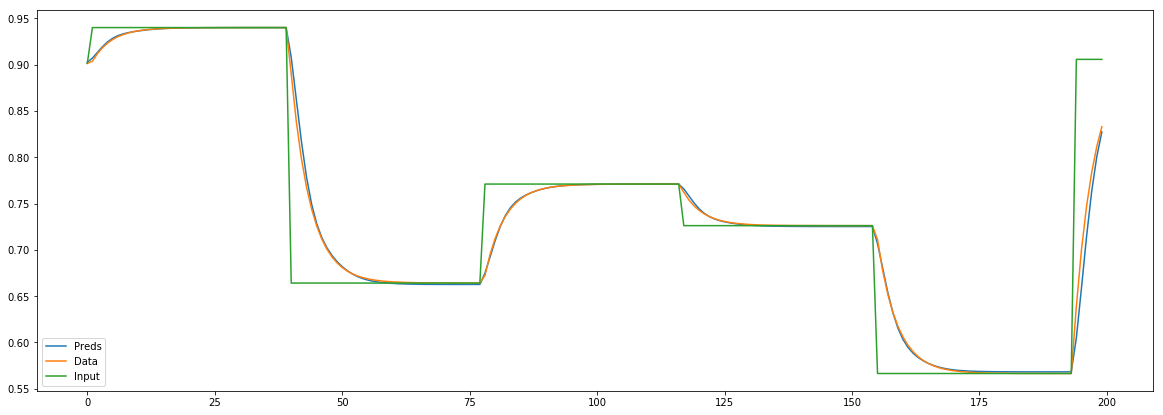

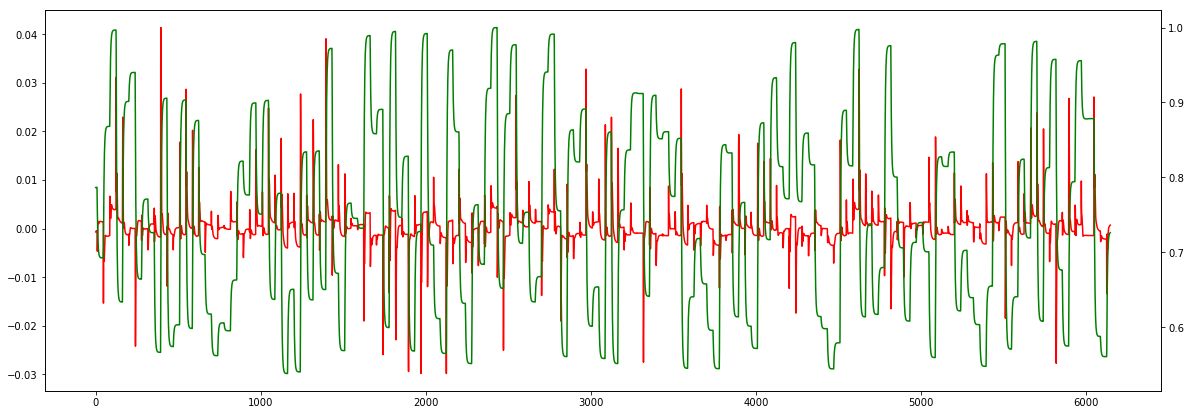

Epoch  2800 MSE:  0.08148929476737976


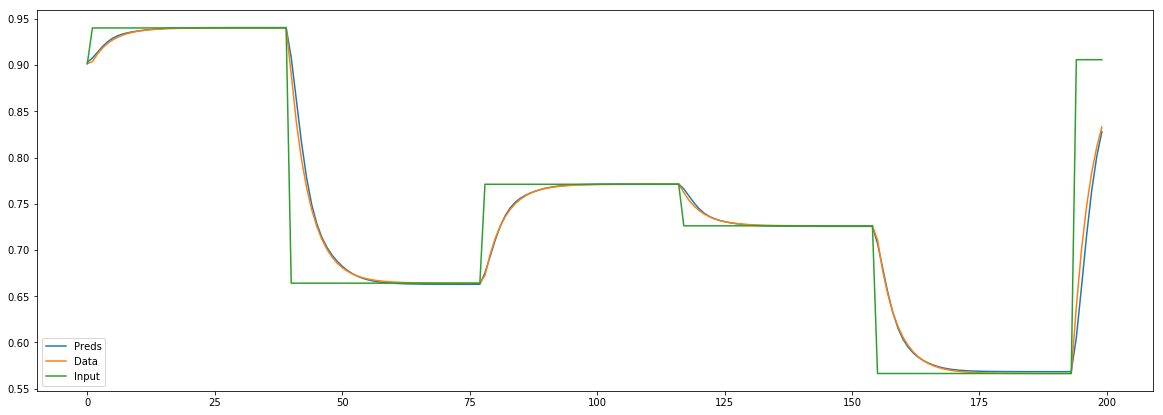

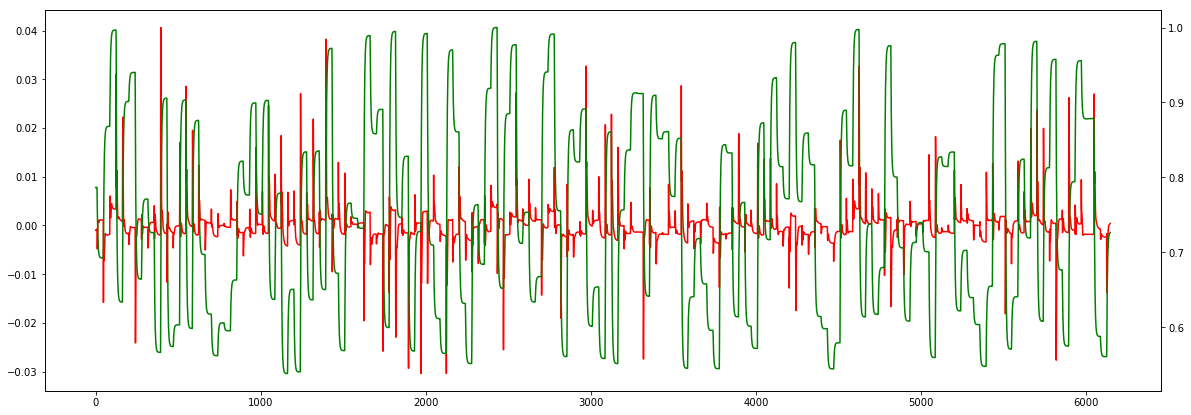

KeyboardInterrupt: 

In [84]:
#####################
# Train model
#####################



model.hidden = model.init_hidden()
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    hist = np.zeros(num_epochs)
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
        
        plt.plot(y_pred[200:400].detach().numpy(), label="Preds")
        plt.plot(y_train[200:400].detach().numpy(), label="Data")
        plt.plot(X_train[input_size-1][200:400].detach().numpy(), label="Input")
        plt.legend()
        plt.show()
        residuals = y_train-y_pred
        plot_multiscale(data=[residuals.detach().numpy(), y_train.detach().numpy()], 
               colors = ["Red", "Green"])
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()


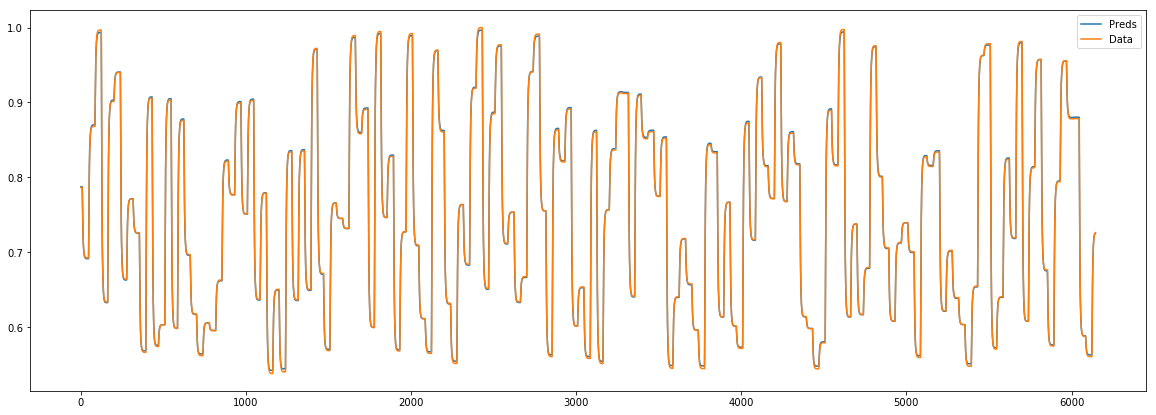

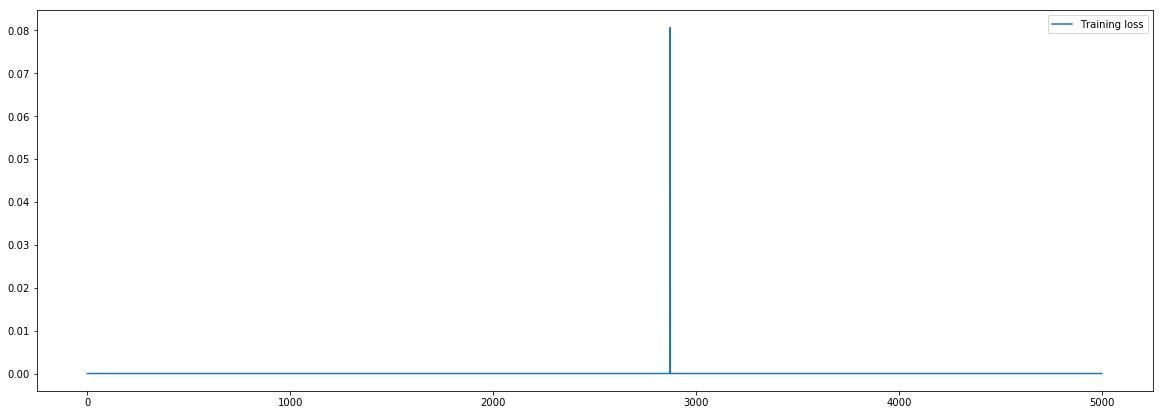

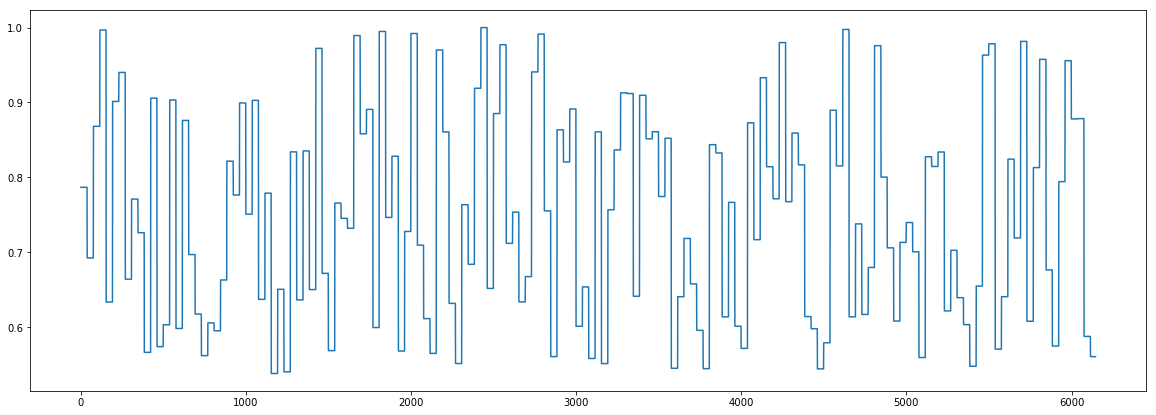

In [85]:

#####################
# Plot preds and performance
#####################
plt.plot(y_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()
plt.plot(X_train[0, :, -1].detach().numpy(), label="ARG")

TEST:

(30, 6146, 1)

(30, 1516, 1)

In [ ]:
# def test_model(model):
   
    
    

In [ ]:
# TODO place it in the training loop for stopping

In [ ]:
# TODO introduce random batch data loader (scikit_learn)
# TODO add getters for next train/test batch

Epoch  2872 MSE:  168.95262145996094


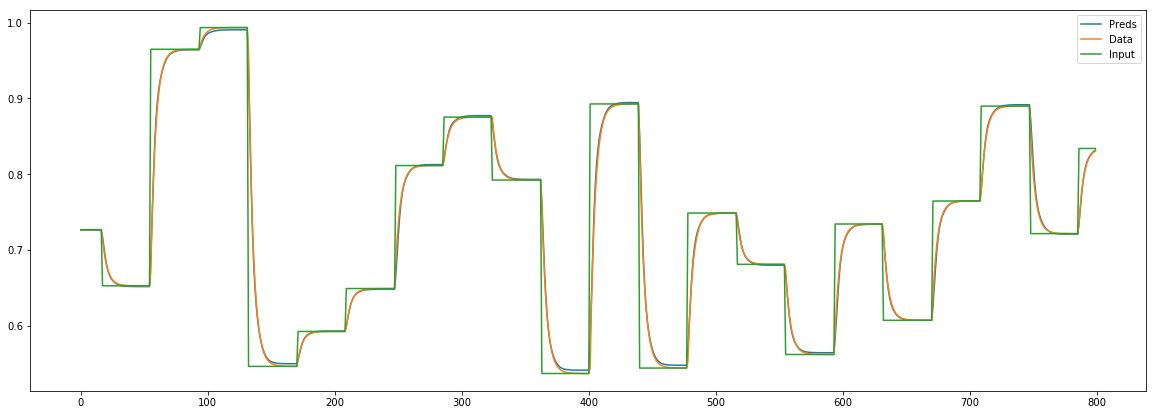

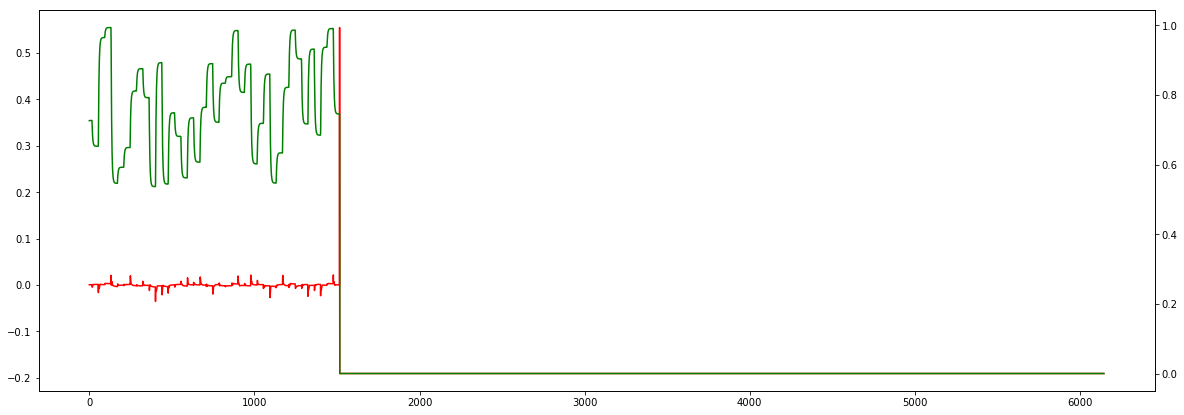

In [122]:
print("Epoch ", t, "MSE: ", loss.item())
plt.plot(y_pred_test[0:800].detach().numpy(), label="Preds")
plt.plot(y_test[0:800].detach().numpy(), label="Data")
plt.plot(X_test[input_size-1][0:800].detach().numpy(), label="Input")
plt.legend()
plt.show()
residuals = y_test-y_pred_test
plot_multiscale(data=[residuals.detach().numpy(), y_test.detach().numpy()], 
       colors = ["Red", "Green"])